In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import missingno as msno
from matplotlib.pyplot import figure
import seaborn as sns
from scipy.stats import norm, skew 
from scipy import stats
from datetime import datetime
import scipy.stats
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score,f1_score
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
import warnings
warnings.filterwarnings(action="ignore")
from tqdm import tqdm
from statsmodels.tsa.ar_model import AutoReg,AR
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import pacf
import json
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
from pymc3.stats import mcse
import arviz as az
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder
import pymc3 as pm
from scipy.stats import boxcox

In [2]:
def check_adf(column):# return p value
    adf_result=adfuller(column)
    if adf_result[1]<=0.05:
        return 'Stationary'
    else:
        return 'Non-Stationary'
    

def get_diff_order(column):
  if check_adf(column)=='Non-Stationary':
    column=column.diff().dropna()
    if check_adf(column)=='Non-Stationary':
        diff_order=2
        column=column.diff().dropna()
    else:
        diff_order=1
  else:
    diff_order=0
  return column,diff_order

def find_Feature_lag(df,target,maxlag,diff_order,p):
    df_sample=df.copy()
    best_aic = np.inf
    best_lag = None
    max_lag=maxlag
    for i in range(1,max_lag+1):
        df_sample[target]=df_sample[target].shift(i)
        df_c=df_sample.dropna()
        model=SARIMAX(df_c[['unweighted_ili']],df_c[target],order=(p,diff_order,0))
        results=model.fit()
        if results.aic<best_aic and results.aic>0:
            best_aic=results.aic 
            best_lag=i
        if best_aic<0 or not best_lag:
            best_lag=2
    return best_lag

def _create_lags(data,maxlag,target,lag=None):
    datax=data.copy()
    for i in datax.columns:
        if i!='state':
          if lag:
            best_lag_value=lag
          #else:
            #best_lag_value=find_Feature_lag(data,i,maxlag,diff_order,p)
          datax[i + "_lag" + str(best_lag_value)]=datax[i].shift(best_lag_value)
          if i!=target:
            datax=datax.drop(i,axis='columns')
    return datax
def best_ili_lag(df,maxlag,diff_order):
    best_aic = np.inf
    best_lag = None
    max_lag=maxlag
    for i in range(1,max_lag+1):
        model=ARIMA(df[['unweighted_ili']],order=(i,1,0))
        results=model.fit()
        if results.aic<best_aic and results.aic>0:
            best_aic=results.aic 
            best_lag=i
        if best_aic<0 or not best_lag:
            best_lag=2
        return best_lag
def _selected_create_lags(data,target,lag_dict):
    datax=data.copy()
    for i in datax.columns:
        if i in lag_dict:
            if isinstance(lag_dict[i], list):
                for l in range(len(lag_dict[i])):
                    lag = int(lag_dict[i][l])
                    datax[i + "_lag" + str(lag)]=datax[i].shift(lag)
            else:
                lag = int(lag_dict[i])
                datax[i + "_lag" + str(lag)]=datax[i].shift(lag)
        if i!=target:
            datax=datax.drop(i,axis='columns')
    return datax

In [4]:
df=pd.read_csv('/kaggle/input/newdata/new_data.csv')
df['date']=pd.to_datetime(df['date'])
df1=(df.set_index('date',drop=True))
states=df1['state'].unique()
df1['school_mode'] = df1['school_mode'].round().astype(int)
df1['elderly_mode'] = df1['elderly_mode'].round().astype(int)
ordinal_encoder = OrdinalEncoder()
ordinal_encoded_values = ordinal_encoder.fit_transform(df1[['school_mode', 'elderly_mode']])
df1[['school_mode', 'elderly_mode']] = ordinal_encoded_values
df1['ILIp']=df1['ILIp']*10000
print(df1.shape)
df1.head(10)

(5919, 12)


,state,elderly_mode,school_mode,unweighted_ili,mask,rr_av7,gp_av7,transit_av7,work_av7,resid_av7,ILIp,pca_1
date,,,,,,,,,,,,
2020-03-01,AL,0.0,0.0,6.32549,0.0000,12.857143,7.285714,10.285714,2.285714,-1.000000,67.239959,38.286813
2020-03-01,AK,0.0,0.0,3.70284,0.0000,11.571429,8.142857,8.857143,3.571429,-0.857143,102.161356,37.121842
2020-03-01,AZ,0.0,0.0,2.31816,0.0615,8.428571,6.000000,6.428571,2.571429,-1.000000,28.907455,32.924371
2020-03-01,AR,0.0,0.0,4.90157,0.0000,17.142857,10.000000,5.857143,3.285714,-2.142857,216.992504,37.846680
2020-03-01,CA,0.0,0.0,3.99147,0.1583,5.142857,5.000000,0.857143,2.428571,-0.714286,80.068888,26.642818
2020-03-01,CO,0.0,0.0,5.82979,0.1030,6.714286,7.714286,2.428571,3.571429,-0.857143,107.559625,29.702890
2020-03-01,CT,0.0,0.0,6.19415,0.0000,6.428571,4.571429,4.714286,2.857143,-0.857143,108.955099,30.288501
2020-03-01,DE,0.0,0.0,2.46723,0.0000,9.714286,4.428571,4.285714,3.142857,-0.857143,35.774835,31.425038
2020-03-01,GA,0.0,0.0,5.44455,0.0001,8.857143,5.142857,4.428571,1.857143,-1.000000,73.610316,31.086173


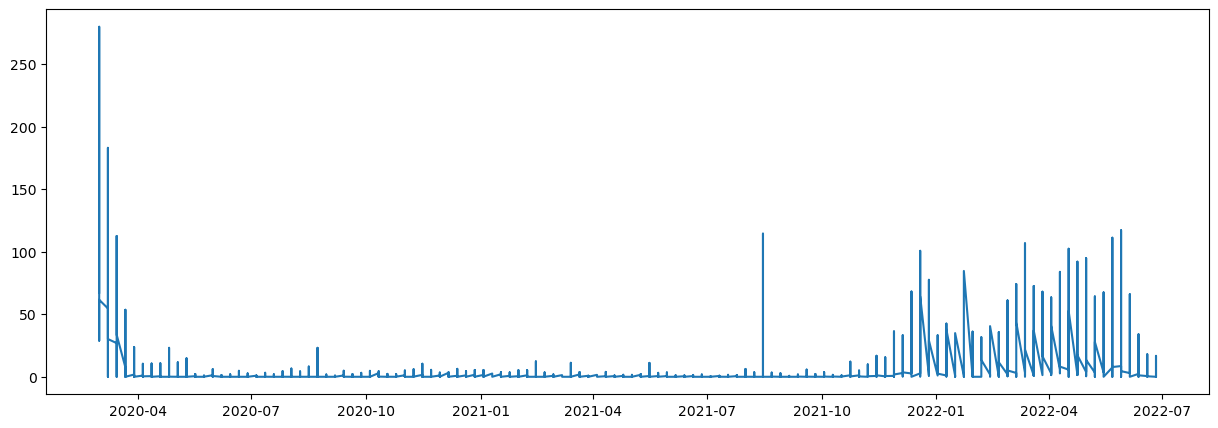

In [5]:
fig, ax = plt.subplots(figsize=(15,5))

plt.plot(df1['ILIp'])

In [6]:
def clean(dataframe):
  Q1 = dataframe['unweighted_ili'].quantile(0.25)
  Q3 = dataframe['unweighted_ili'].quantile(0.75)
  IQR = Q3 - Q1
  median = dataframe['unweighted_ili'].median()
  dataframe = dataframe[(dataframe['unweighted_ili'] >0) & (dataframe['unweighted_ili'] <= median + 1.5*IQR)]
  return dataframe
def return_state_data(data,state,start_date,end_date,cols,target_variable,lag_dict=None,own_lag_selection=True,lagg=None):
  df1_st=data[data['state']==state][start_date:end_date]
  df2_st=df1_st[cols]
  if own_lag_selection:
    data_new=_selected_create_lags(data=df2_st.dropna(),target=target_variable,lag_dict=lag_dict)
  else:
      data_new=_create_lags(data=df2_st.dropna(),maxlag=4,target=target_variable,lag=lagg)# p wnt work here, as i have put lagg even for ili-lagg
  df_c1=data_new.dropna()
  return df_c1
def compute_log_model_evidence(trace, model):
    logp = 0
    for i in range(trace.nchains):
        logp += np.sum(model.logp(trace.point(i)))
    logp /= trace.nchains
    logp_prior = model.logp(model.test_point).sum()

In [7]:
class Model:
    def __init__(self, county_idxs, new_dat_mat, coords,categorical=True):
        self.county_idxs = county_idxs
        self.new_dat_mat = new_dat_mat
        self.coords = coords
        self.model = None
        self.trace = None
        if categorical:
            self.categorical=categorical
        self.categorical_school=new_dat_mat[:,1]
        #self.categorical_elderly=new_dat_mat[:,1]
        self.school_mode_values = np.unique(self.categorical_school)
        self.school_mode_idx = np.searchsorted(self.school_mode_values , self.categorical_school)
        #self.elderly_mode_values = np.unique(self.categorical_elderly)
        #self.elderly_mode_idx = np.searchsorted(self.elderly_mode_values, self.categorical_elderly)
    def build_model(self,model_distribution):
        with pm.Model(coords=self.coords) as hierarchical_model:
            #PRIORS
            b_pca= pm.Normal('b_pca', mu=0., sigma=1)
            b_masking= pm.Normal('b_masking', mu=0., sigma=1)
            if  hasattr(self, 'categorical') and self.categorical:
                b_school= pm.Normal('b_school', mu=0., sigma=1,dims='school_mode' )
                school_category = pm.Data('school_mode', self.categorical_school, dims='obs_id')
                #b_elderly= pm.Normal('b_elderly', mu=0., sigma=1,dims='elderly_mode')
                #elderly_category = pm.Data('elderly_mode', self.categorical_elderly, dims='obs_id')
            else:
                b_school= pm.Normal('b_school', mu=0., sigma=1)
                #b_elderly= pm.Normal('b_elderly', mu=0., sigma=1)
            mu_a = pm.Normal('mu_a', mu=0., sigma=1)
            sigma_a = pm.HalfCauchy('sigma_a', beta=1)

            #hierarchical part
            county_idx = pm.Data("county_idx",self.county_idxs , dims="obs_id")
            floor = pm.Data("floor", self.new_dat_mat[:,0], dims="obs_id")
            b_ili_lag_1 = pm.Normal(f'ili_lag_{county_idx}_1', mu=0, sigma=1,dims="county")
            #b_ili_lag_2 = pm.Normal(f'ili_lag_{county_idx}_2', mu=0, sigma=1,dims="county")
            #b_ili_lag_3 = pm.Normal(f'ili_lag_{county_idx}_3', mu=0, sigma=1,dims="county")
            #b_ili_lag_4 = pm.Normal(f'ili_lag_{county_idx}_4', mu=0, sigma=1,dims="county")

            a = pm.Normal(f'alpha_{county_idx}', mu=mu_a, sigma=sigma_a,dims="county")
            if hasattr(self, 'categorical') and self.categorical:
                """formula= (a[county_idx] + b_ili_lag_1[county_idx]*self.new_dat_mat[:,3] + b_masking*self.new_dat_mat[:,7]+
                b_school[self.school_mode_idx]*self.new_dat_mat[:,2]+b_elderly[self.elderly_mode_idx]*self.new_dat_mat[:,1] +
                b_pca*self.new_dat_mat[:,8] +  b_ili_lag_2[county_idx]*self.new_dat_mat[:,4] +  b_ili_lag_3[county_idx]*self.new_dat_mat[:,5]
                         + b_ili_lag_4[county_idx]*self.new_dat_mat[:,6])"""
                formula= (a[county_idx] + b_ili_lag_1[county_idx]*self.new_dat_mat[:,2] + b_masking*self.new_dat_mat[:,3]+
                 b_school[self.school_mode_idx]*self.new_dat_mat[:,1] 
                          + b_pca*self.new_dat_mat[:,4])
            else:
                formula= (a[county_idx] + b_ili_lag[county_idx]*self.new_dat_mat[:,3] + b_masking*self.new_dat_mat[:,4]+
                         b_school*self.new_dat_mat[:,2] + b_elderly*self.new_dat_mat[:,1]+b_pca_*self.new_dat_mat[:,5])
            eps = pm.HalfCauchy("eps", 1)
            if model_distribution=='Poisson':
                pm.Poisson(f'y_like_{county_idx}', mu=np.exp(formula), observed=floor)
            elif model_distribution=='Normal':
                pm.Normal(f'y_like_{county_idx}', mu=formula,sigma=eps,observed=floor) 
    
            self.model = hierarchical_model

    def fit_model(self,model_distribution, draws=5000, step=None):
        if self.model is None:
            self.build_model(model_distribution)

        with self.model:
            if step=='Metropolis':
                self.trace = pm.sample(draws=draws, step=pm.Metropolis())
            elif step=='Nuts':
                self.trace=pm.sample(draws=draws)
        return self.trace,self.model

    def plot_trace(self,cols):
        if self.trace is None:
            raise ValueError("Trace is not available. You need to fit the model first.")

        az.plot_posterior(self.trace, var_names=cols,kind='hist')
    def get_posteriors(self):
        return pm.sample_posterior_predictive(self.trace, model=self.model)
    def get_waic(self):
        waic=pm.waic(self.trace, self.model)
        return round(waic.waic,3)
    def get_summary(self):
        return pm.summary(self.trace)[['mean','sd','hdi_3%','hdi_97%']]
    def get_bic(self):
        log_likelihood=compute_log_model_evidence(self.trace,self.model)
        bic = -2 * log_likelihood + np.log(len(self.new_dat_mat)) * (model_graph.ndim)
        return bic

In [9]:
def transformed_data(dataframe,no_of_columns,start_date,end_date,cols,target_variable,lag_dict=None,lagg=None): 
    dat_mat = np.zeros((len(states)*100,no_of_columns+1))
    state_idx=1
    for state in states: 
        if state not in ['FL']: 
            if lag_dict and not lagg:
                tmp=return_state_data(dataframe,state,start_date,end_date,cols,target_variable,lag_dict=lag_dict,own_lag_selection=True).to_numpy()
            else:
                tmp = return_state_data(dataframe,state,lagg,start_date,end_date,cols,target_variable,lagg=lagg).to_numpy()
            tmp = np.concatenate((tmp,np.repeat(state_idx,tmp.shape[0]).reshape((-1,1))),axis=1)
            dat_mat = np.append(dat_mat,tmp,axis=0)

            state_idx += 1
    new_dat_mat = dat_mat[dat_mat[:, no_of_columns] != 0]
    county_idxs, counties = pd.factorize(new_dat_mat[:,no_of_columns])
    n_school_modes = len(np.unique(new_dat_mat[:, 2]))
    n_elderly_modes = len(np.unique(new_dat_mat[:, 1]))
    coords = {
        "county": counties,
        "obs_id": range(new_dat_mat.shape[0]),
        "school_mode":np.arange(0,4),
        "elderly_mode":np.arange(1,4)
    }
    return new_dat_mat,coords,county_idxs

In [10]:
perc_lag_dict={'mask':2,'percent_positive':4,'elderly_mode':4,'school_mode':3,'pca_1':4}
ili_lag_dict={'mask':4,'unweighted_ili':4,'elderly_mode':4,'school_mode':3,'pca_1':1}
ILIp_dict={'mask':4,'ILIp':[1],'elderly_mode':3,'school_mode':1,'pca_1':4}
s=return_state_data(df1,'AK','2020-01-01','2022-06-26',cols=['elderly_mode','school_mode', 'ILIp', 'mask', 'pca_1'],
                  target_variable='ILIp',lag_dict=ILIp_dict,own_lag_selection=True)
s.head(5)

,ILIp,elderly_mode_lag3,school_mode_lag1,ILIp_lag1,mask_lag4,pca_1_lag4
date,,,,,,
2020-03-29,0.000000,0.0,3.0,0.0,0.0000,37.121842
2020-04-05,0.000000,1.0,3.0,0.0,0.0000,32.054324
2020-04-12,0.000000,2.0,3.0,0.0,0.0035,20.124834
2020-04-19,0.000000,2.0,3.0,0.0,0.1201,-28.344461
2020-04-26,0.392313,2.0,3.0,0.0,0.2187,-51.249776


In [11]:
new_dat_mat, coords, county_idxs = transformed_data(dataframe=df1, no_of_columns=5,
                                                    start_date='2020-01-1', end_date='2022-06-26',
                                                cols=['school_mode', 'ILIp', 'mask', 'pca_1'],
                                                    target_variable='ILIp',lag_dict=ILIp_dict)
print(new_dat_mat.shape)
pd.DataFrame(new_dat_mat).head(5)

(5684, 6)


,0,1,2,3,4,5
0,1.781412,2.0,7.574854,0.0000,38.286813,1.0
1,0.967903,3.0,1.781412,0.0000,36.947238,1.0
2,0.516900,3.0,0.967903,0.0034,28.545433,1.0
3,0.414478,3.0,0.516900,0.1170,-12.920219,1.0
4,0.000000,3.0,0.414478,0.2133,-24.022998,1.0


In [13]:
model = Model(county_idxs, new_dat_mat, coords,categorical=True)    
trace,model_graph= model.fit_model(model_distribution='Poisson', draws=10000, step='Metropolis')
waic = model.get_waic()
summary = model.get_summary()
ppc=model.get_posteriors()
summary['waic'] = waic

In [14]:
print(trace.varnames)
summary[:30]

['b_pca', 'b_masking', 'b_school', 'mu_a', 'sigma_a_log__', 'ili_lag_county_idx_1', 'alpha_county_idx', 'eps_log__', 'sigma_a', 'eps']


,mean,sd,hdi_3%,hdi_97%,waic
b_pca,0.005,0.001,0.004,0.007,-22964.117
b_masking,0.076,0.096,-0.104,0.243,-22964.117
b_school[0],1.554,0.766,0.350,2.791,-22964.117
b_school[1],0.700,0.082,0.540,0.840,-22964.117
b_school[2],-0.455,0.037,-0.521,-0.386,-22964.117
b_school[3],-0.524,0.033,-0.584,-0.464,-22964.117
mu_a,0.000,0.000,-0.000,0.001,-22964.117
ili_lag_county_idx_1[1.0],0.028,0.060,-0.042,0.115,-22964.117
ili_lag_county_idx_1[2.0],0.063,0.015,0.033,0.087,-22964.117
ili_lag_county_idx_1[3.0],0.137,0.021,0.106,0.156,-22964.117


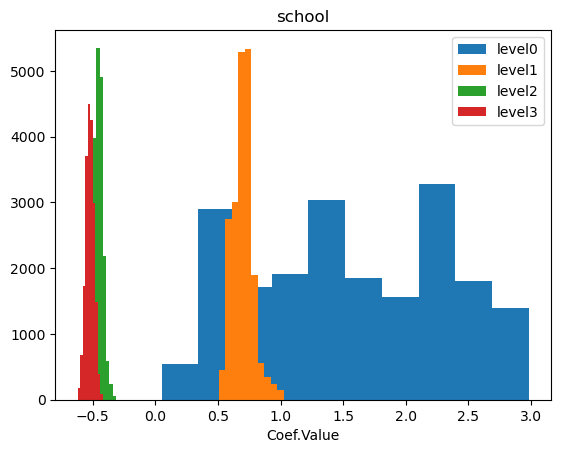

In [15]:
plt.hist(trace['b_school'][:,0],label='level0')
plt.hist(trace['b_school'][:,1],label='level1')
plt.hist(trace['b_school'][:,2],label='level2')
plt.hist(trace['b_school'][:,3],label='level3')
plt.title('school')
plt.xlabel('Coef.Value')
plt.legend()

array([[<AxesSubplot:title={'center':'b_pca'}>,
        <AxesSubplot:title={'center':'b_pca'}>],
       [<AxesSubplot:title={'center':'b_masking'}>,
        <AxesSubplot:title={'center':'b_masking'}>],
       [<AxesSubplot:title={'center':'b_school'}>,
        <AxesSubplot:title={'center':'b_school'}>]], dtype=object)

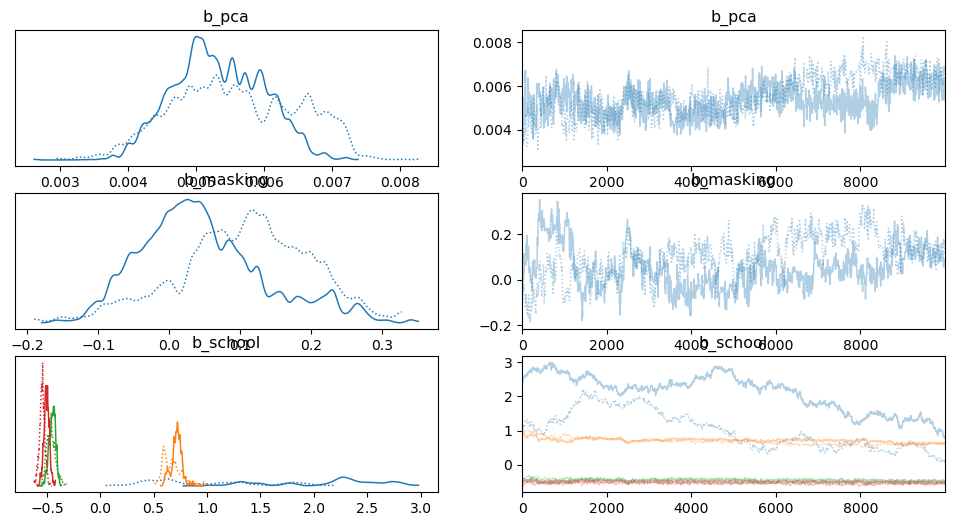

In [16]:
az.plot_trace(trace, var_names=["b_pca", "b_masking", "b_school"])


In [17]:
summary[['interpret_mean', 'interpret_hdi_3%','interpret_hdi_97%']] = summary[['mean', 'hdi_3%','hdi_97%']].apply(lambda x: (np.exp(x)-1)*100)
summary[:10]

,mean,sd,hdi_3%,hdi_97%,waic,interpret_mean,interpret_hdi_3%,interpret_hdi_97%
b_pca,0.005,0.001,0.004,0.007,-22964.117,0.501252,0.400801,0.702456
b_masking,0.076,0.096,-0.104,0.243,-22964.117,7.896257,-9.877470,27.506862
b_school[0],1.554,0.766,0.350,2.791,-22964.117,373.035381,41.906755,1529.730896
b_school[1],0.700,0.082,0.540,0.840,-22964.117,101.375271,71.600686,131.636698
b_school[2],-0.455,0.037,-0.521,-0.386,-22964.117,-36.555203,-40.607368,-32.022947
b_school[3],-0.524,0.033,-0.584,-0.464,-22964.117,-40.785278,-44.233675,-37.123645
mu_a,0.000,0.000,-0.000,0.001,-22964.117,0.000000,0.000000,0.100050
ili_lag_county_idx_1[1.0],0.028,0.060,-0.042,0.115,-22964.117,2.839568,-4.113022,12.187344
ili_lag_county_idx_1[2.0],0.063,0.015,0.033,0.087,-22964.117,6.502684,3.355054,9.089668
ili_lag_county_idx_1[3.0],0.137,0.021,0.106,0.156,-22964.117,14.682815,11.182188,16.882620


In [ ]:
"""df_new=summary.loc[['b_pca_','b_masking']]
fig, ax = plt.subplots()

ax.errorbar(df_new.index, (np.exp(df_new['mean'])-1)*100, yerr=[(np.exp(df_new['mean'])-1)*100 - (np.exp(df_new['hdi_3%'])-1)*100, 
                                                                (np.exp(df_new['hdi_97%'])-1)*100 - (np.exp(df_new['mean'])-1)*100], fmt='o')
ax.set_xticklabels(df_new.index)
ax.set_xlabel('variables')
ax.set_ylabel('change in percent_positive %')
plt.show()"""

In [ ]:
"""#['b_pca_','b_masking','b_school[0]','b_school[1]','b_school[2]','b_school[3]',
                    #'b_elderly[0]','b_elderly[1]','b_elderly[2]','b_elderly[3]']
var_to_plot=['b_elderly[1]','b_elderly[2]','b_elderly[3]']
fig, ax = plt.subplots()

for variable, group in df_summary2.groupby('Variable'):
    if variable  in var_to_plot:
        ax.plot(group['lag'], (np.exp(group['mean'])-1)*100, label=variable)
for variable, group in df_summary2.groupby('Variable'):
    if variable in var_to_plot:
        ax.fill_between(group['lag'], (np.exp(group['hdi_3%'])-1)*100, (np.exp(group['hdi_97%'])-1)*100, alpha=0.1, color='blue')
        ax.plot(group['lag'], (np.exp(group['hdi_3%'])-1)*100, '--', color='black', alpha=0.5)
        ax.plot(group['lag'], (np.exp(group['hdi_97%'])-1)*100, '--', color='black', alpha=0.5)

ax.set_xlabel('Week (Lag)')
ax.set_ylabel('change_in_ili %')
ax.legend(title='Variable')
plt.show()"""

In [18]:
accuracies=[]
pred=ppc['y_like_county_idx']
print(pred.shape)
for i in range(1,51):
    state_idxs = np.where(new_dat_mat[:,5] == i)[0]
    state_preds = pred[:, state_idxs]
    mean_pred=state_preds.mean(axis=0)
    observed=new_dat_mat[new_dat_mat[:,5] == i,0]
    if len(observed)>0:
        r2 = r2_score(observed, mean_pred)
        accuracies.append(r2)
        print(f"Accuracy for index {i}: {r2}")
print(f"Average accuracy: {np.mean(accuracies)}")

(20000, 5684)
Accuracy for index 1: -0.0018472983415895872
Accuracy for index 2: 0.1698264388467028
Accuracy for index 3: 0.5591960461594174
Accuracy for index 4: 0.13936990168358288
Accuracy for index 5: 0.6866832250431385
Accuracy for index 6: 0.5040278378669516
Accuracy for index 7: 0.6125012106479513
Accuracy for index 8: 0.3312885658722534
Accuracy for index 9: 0.18871428933420198
Accuracy for index 10: 0.40871146656289814
Accuracy for index 11: -0.1903395115436637
Accuracy for index 12: 0.6542496275425782
Accuracy for index 13: 0.46983023768498544
Accuracy for index 14: 0.6203065256515462
Accuracy for index 15: 0.1442515291380403
Accuracy for index 16: 0.2727285876283766
Accuracy for index 17: 0.06993195478420522
Accuracy for index 18: 0.06347148203340103
Accuracy for index 19: 0.3085208783262642
Accuracy for index 20: 0.5787695812433593
Accuracy for index 21: 0.47303915825225806
Accuracy for index 22: 0.343942543812653
Accuracy for index 23: -0.40354019573664957
Accuracy for ind

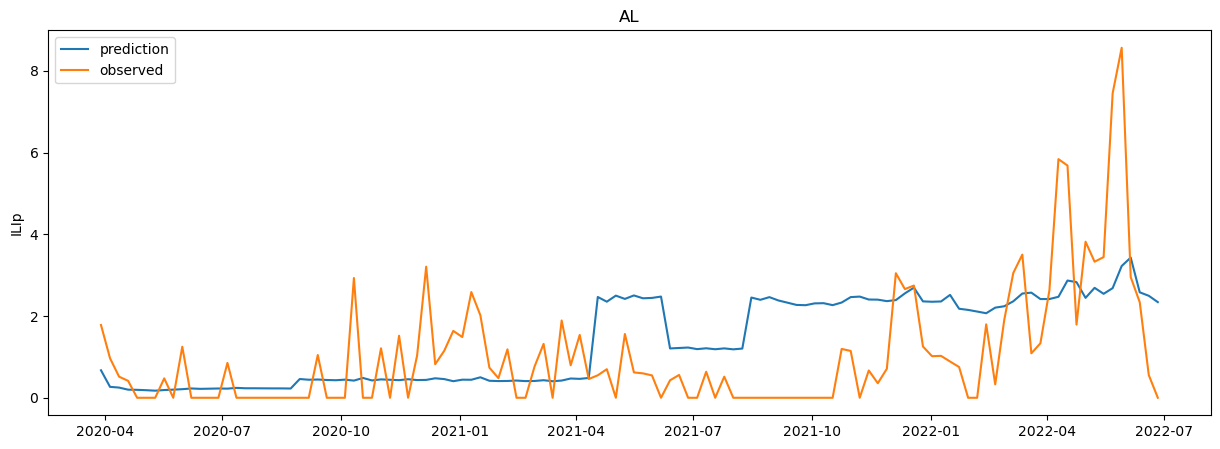

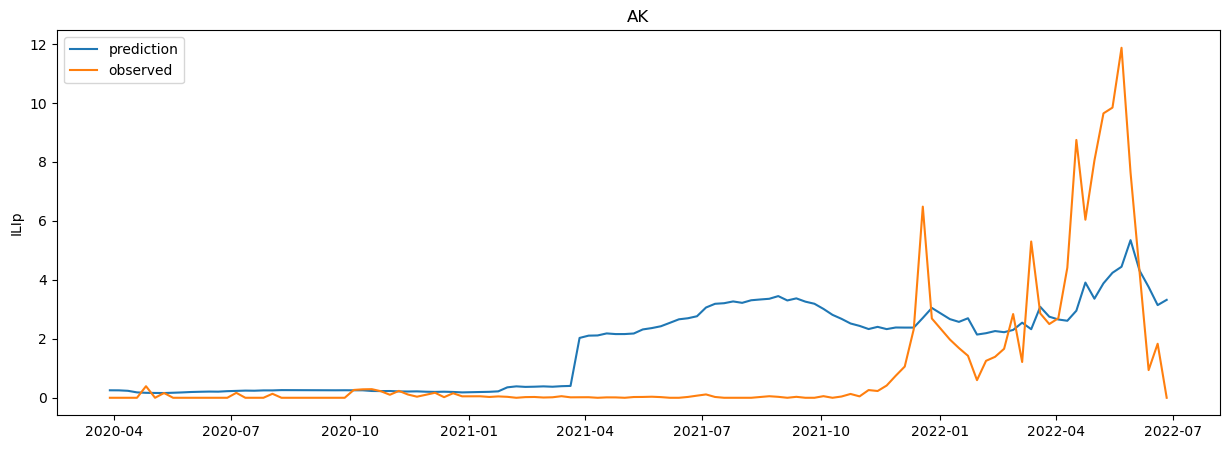

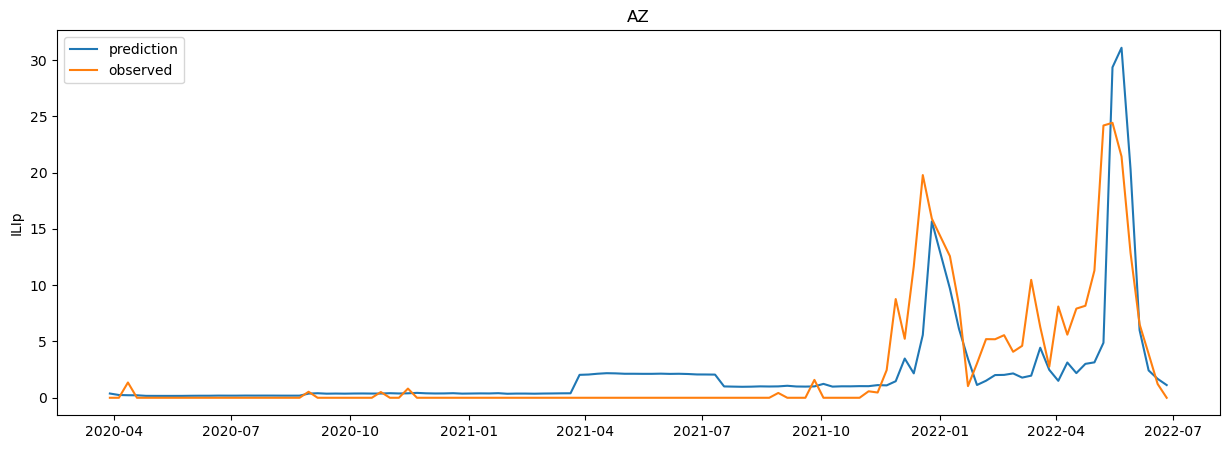

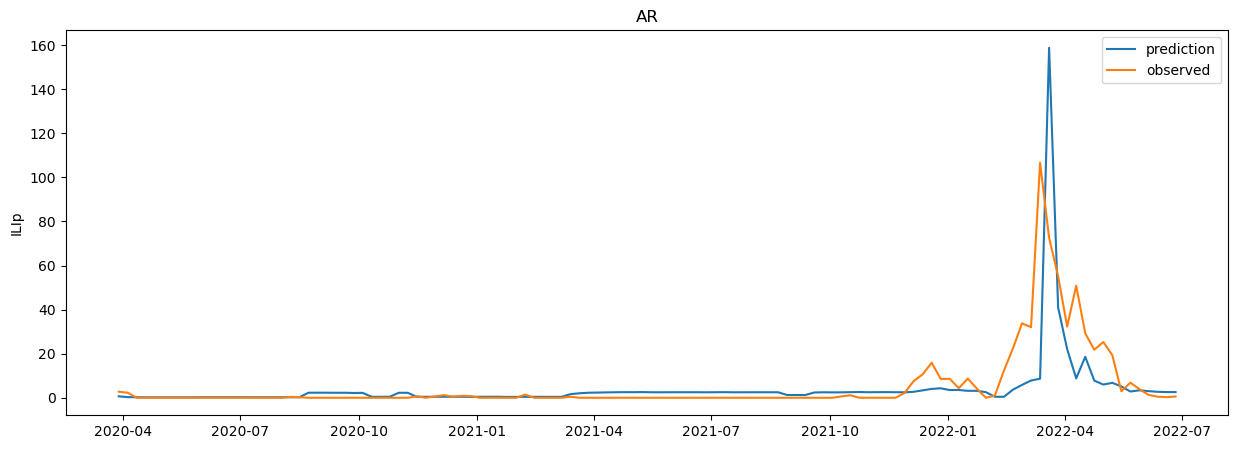

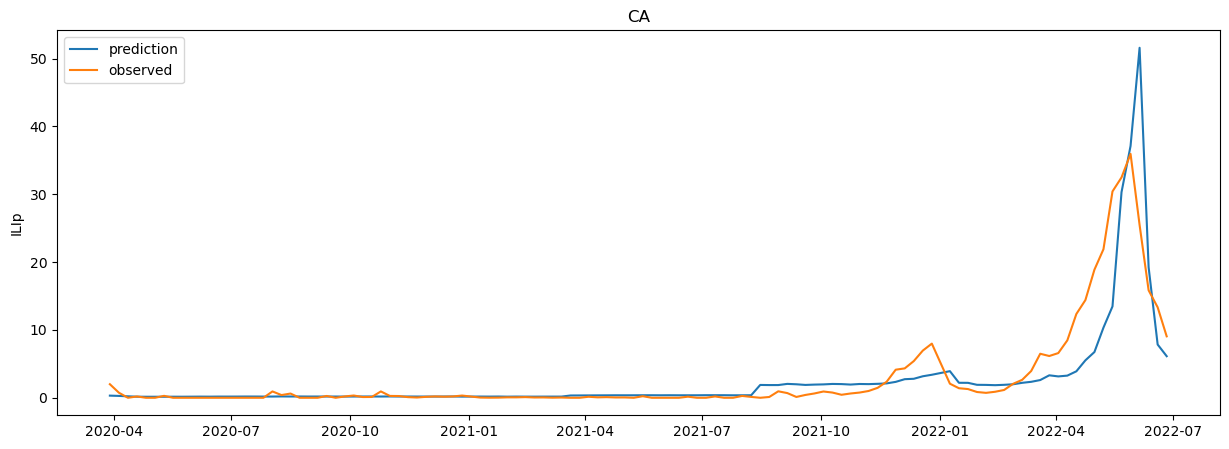

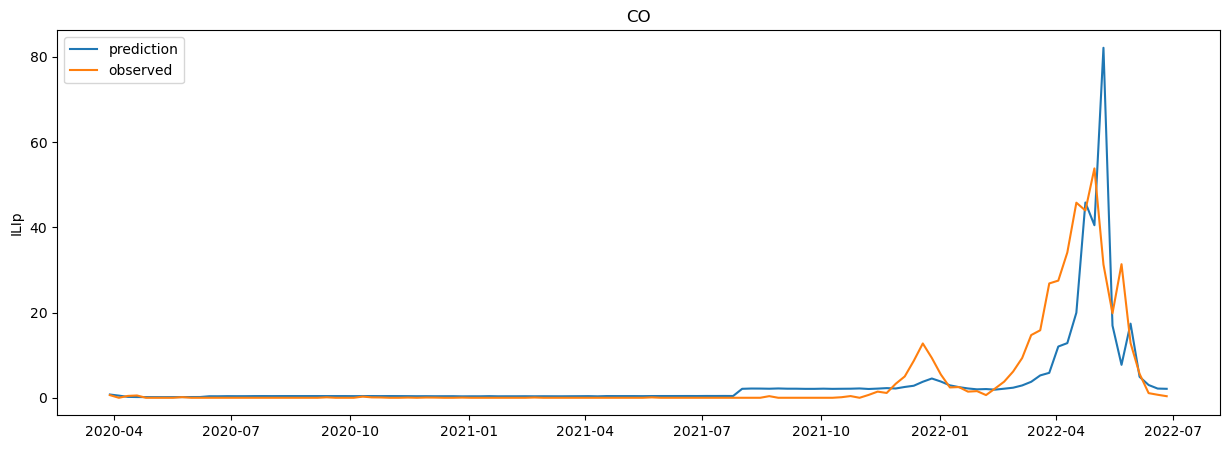

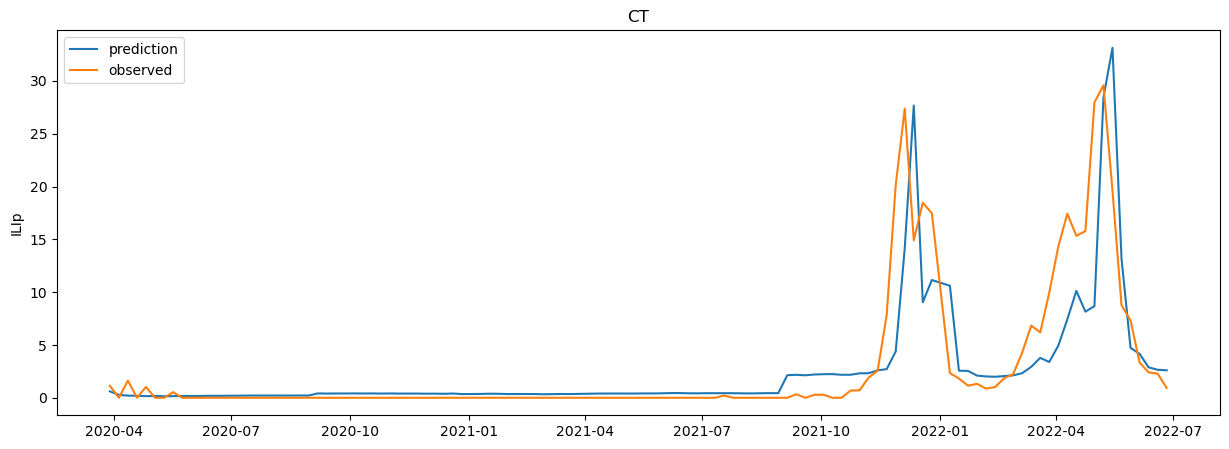

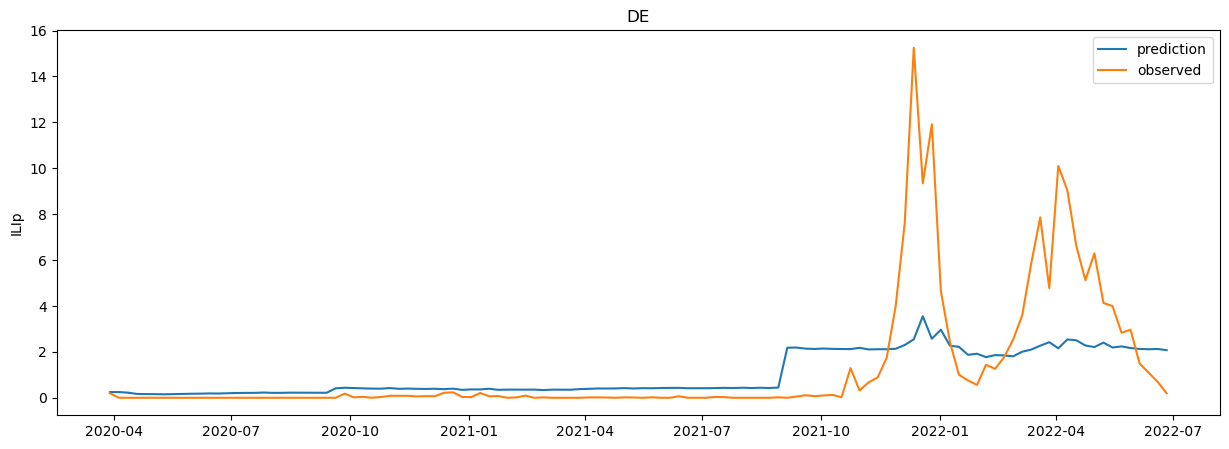

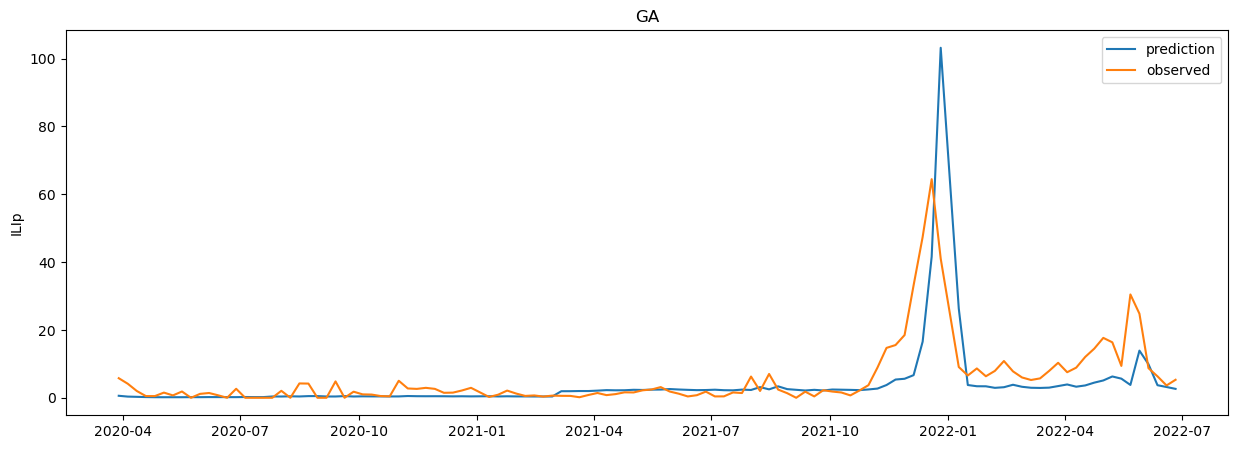

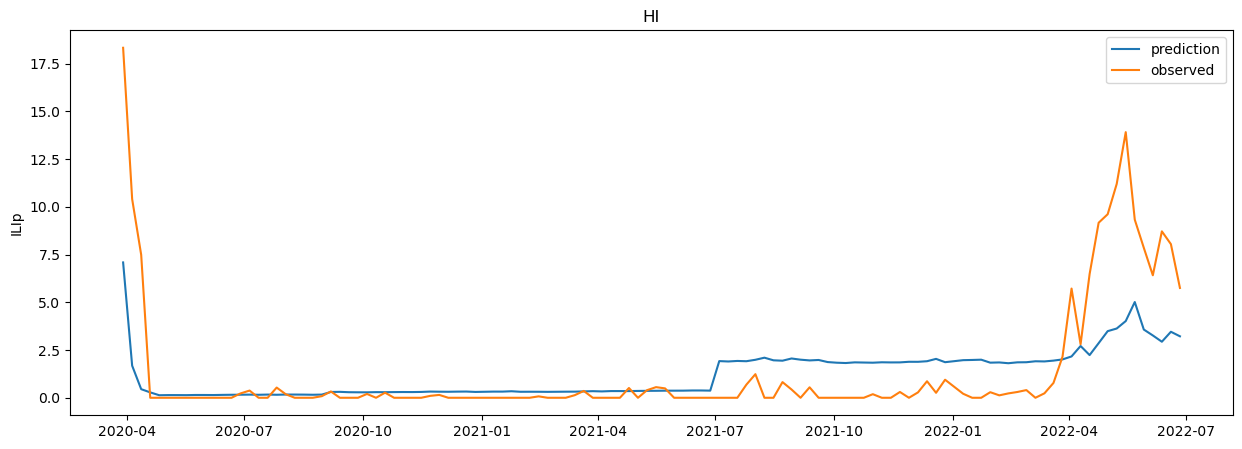

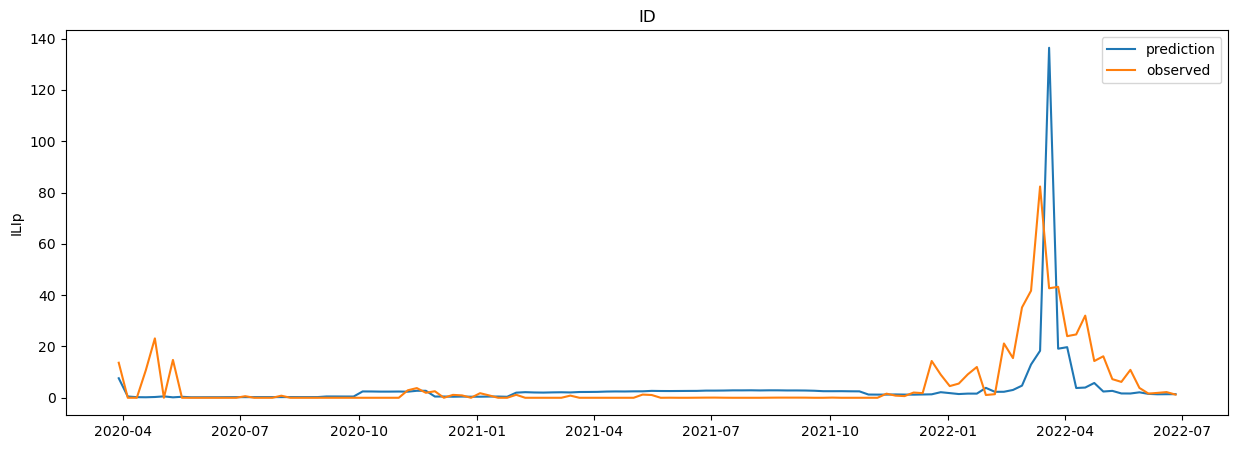

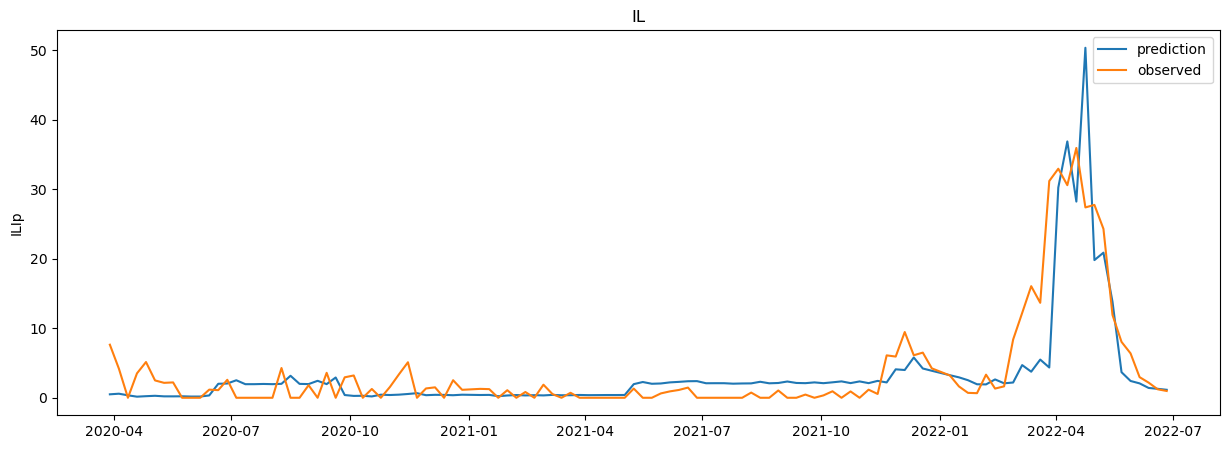

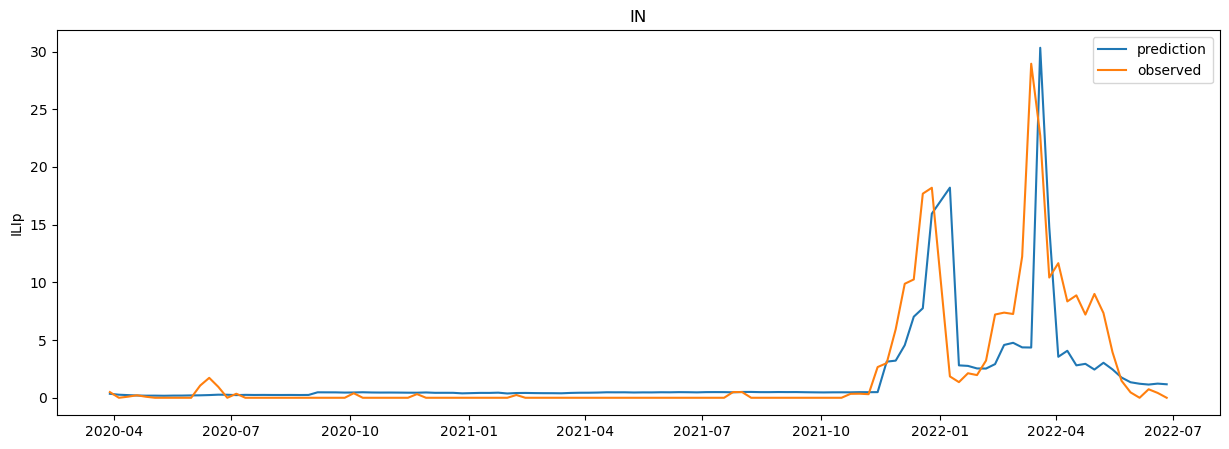

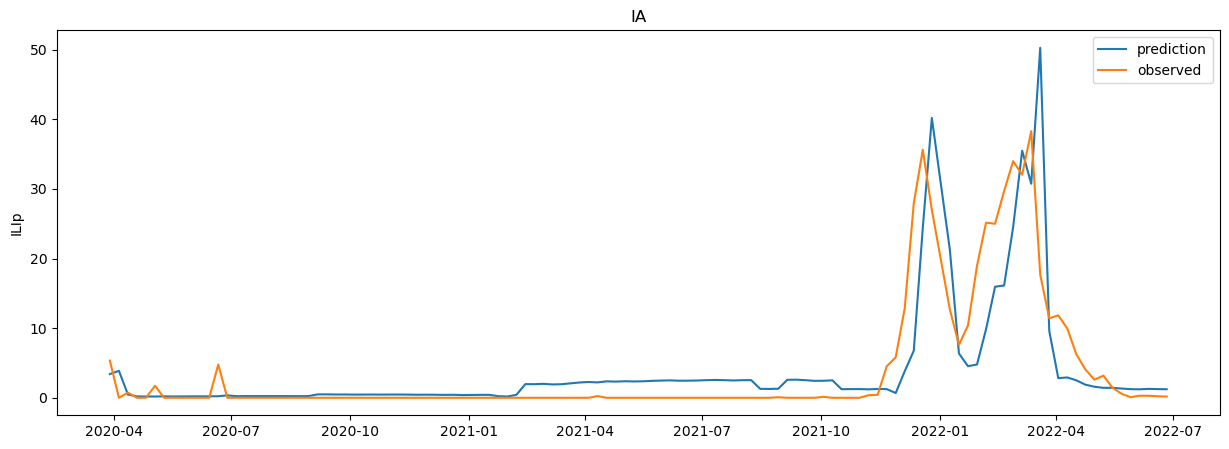

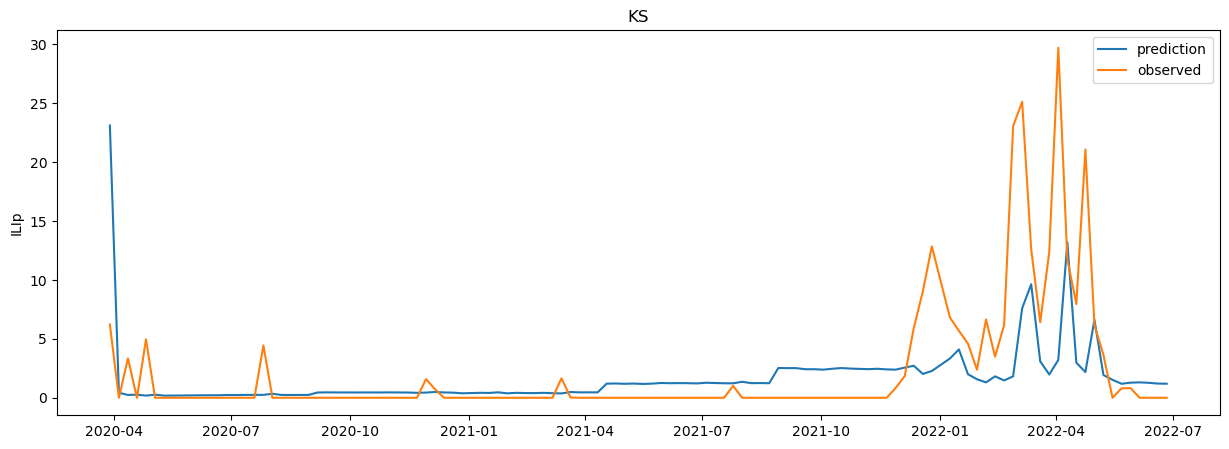

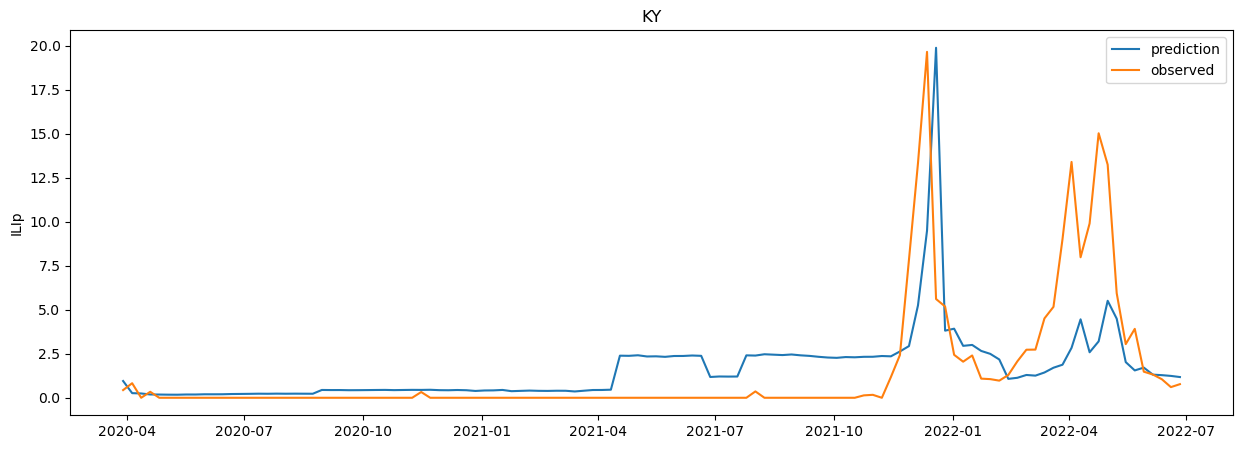

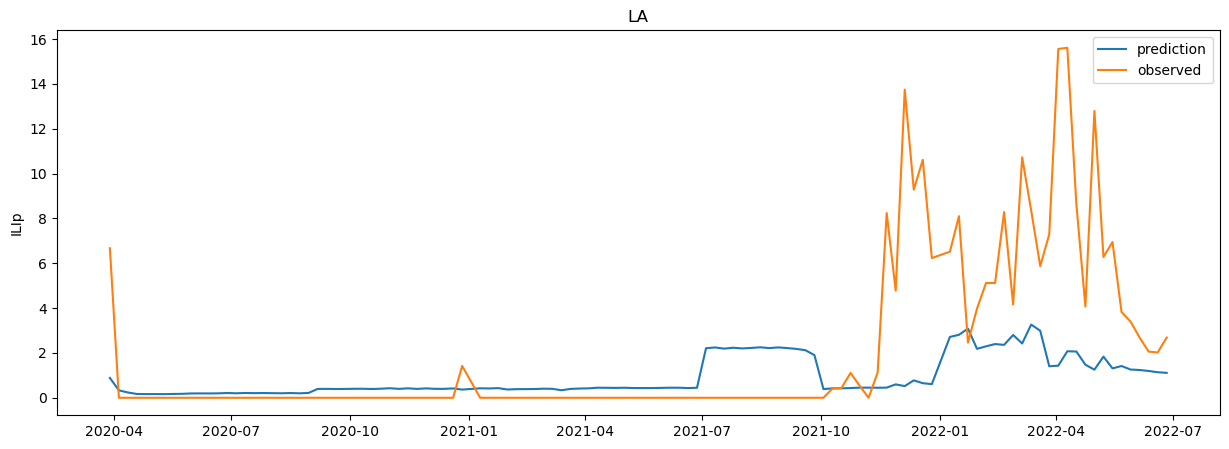

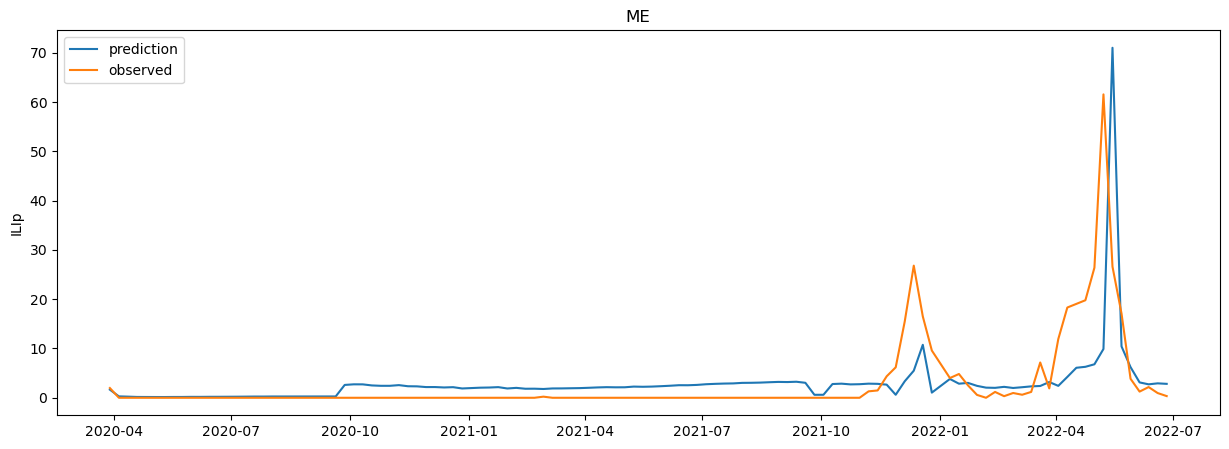

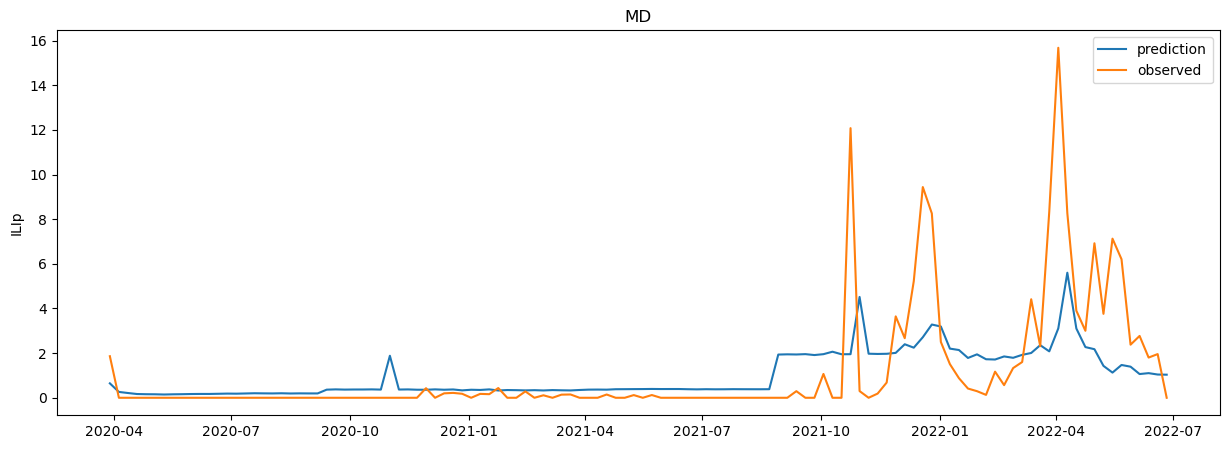

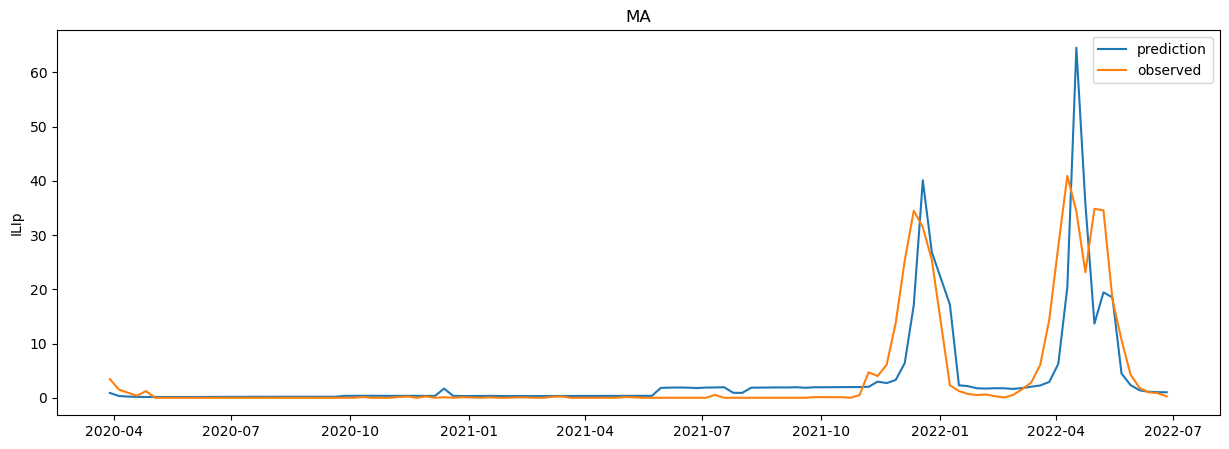

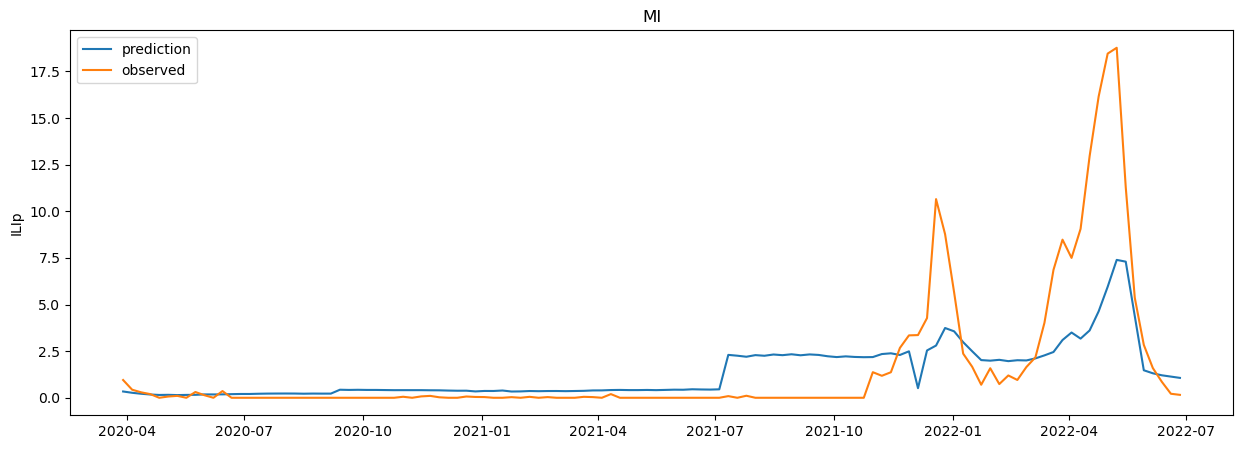

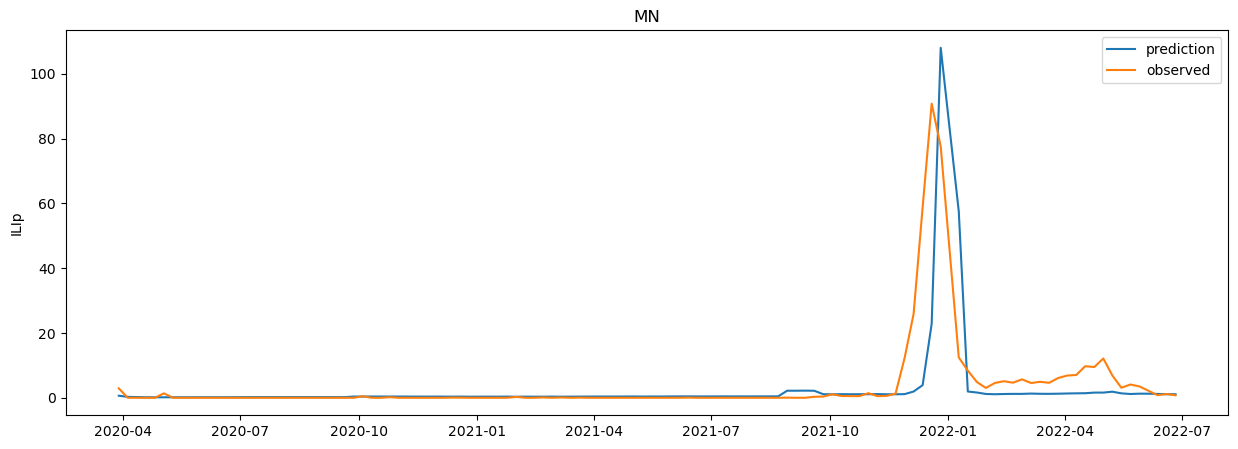

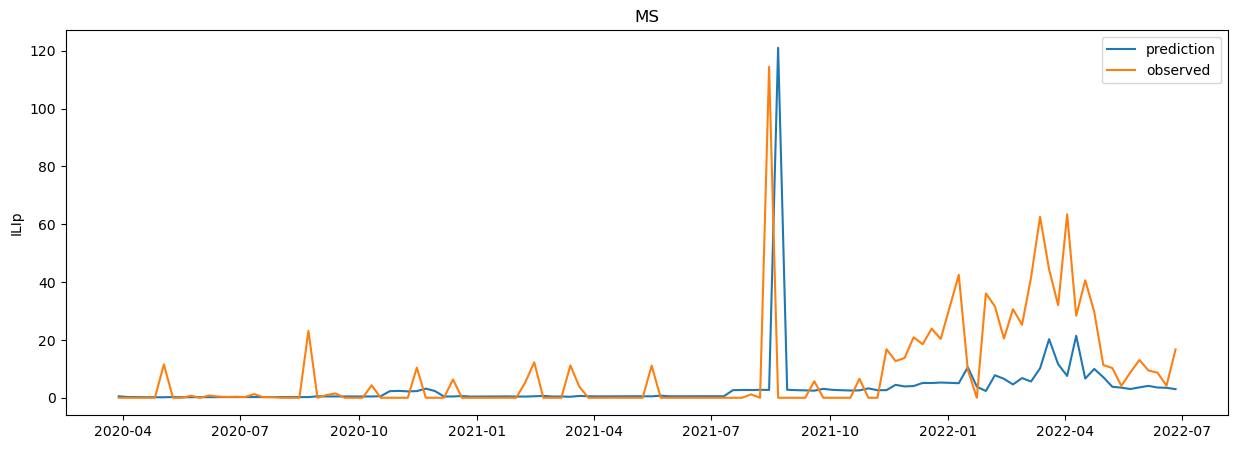

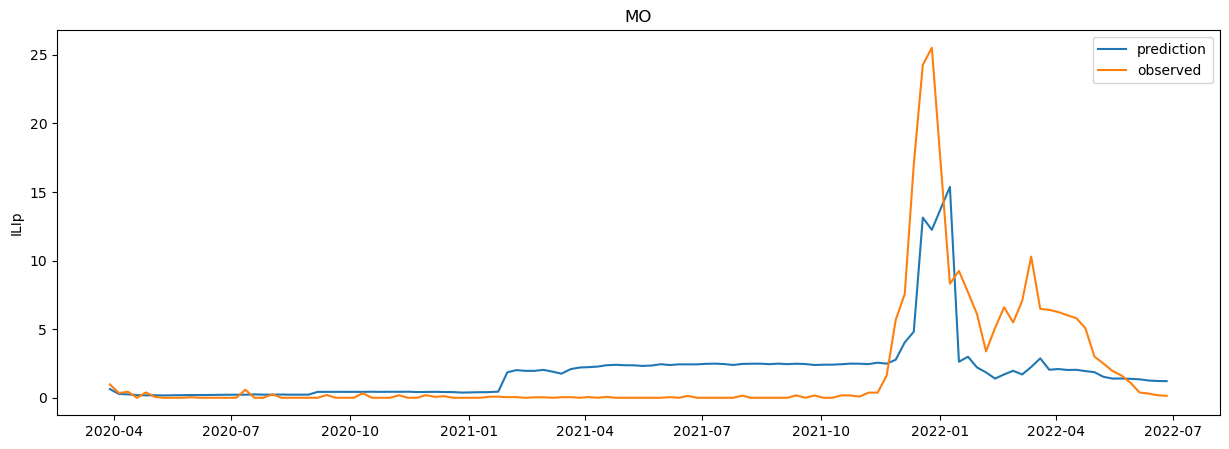

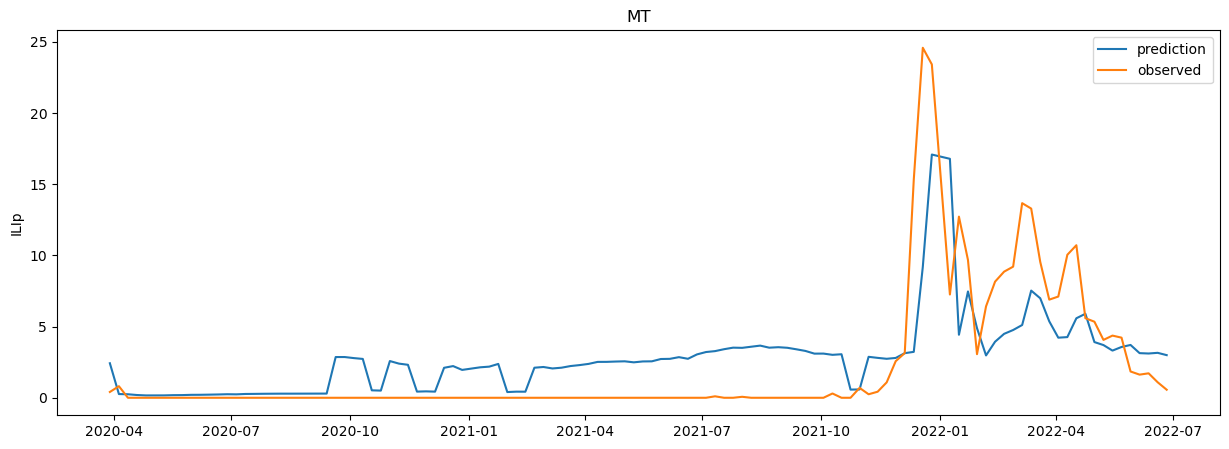

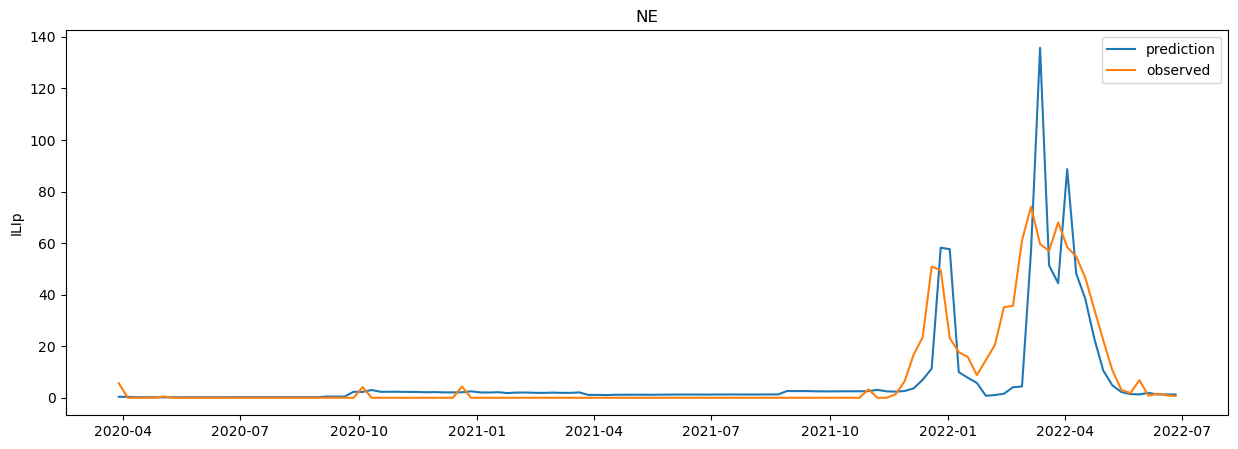

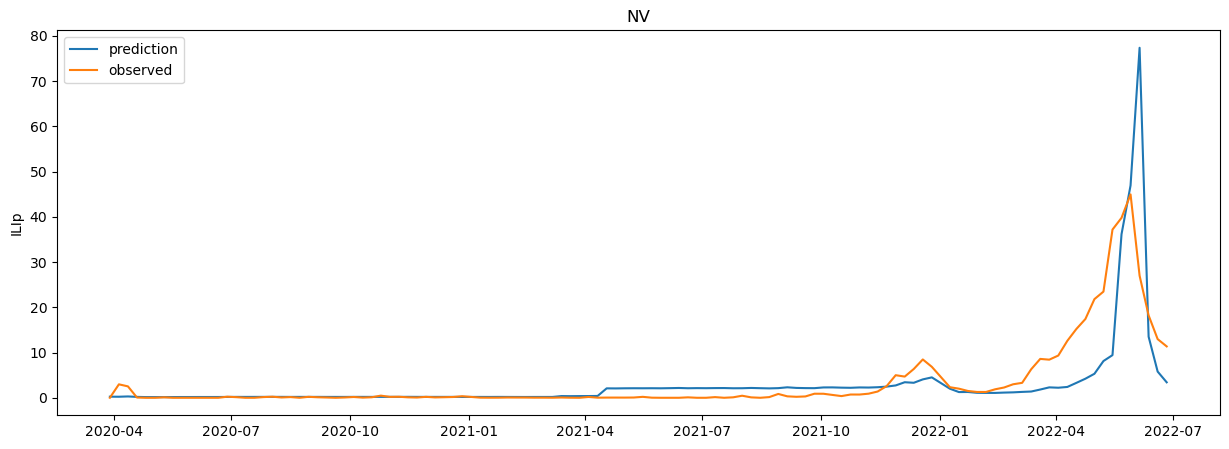

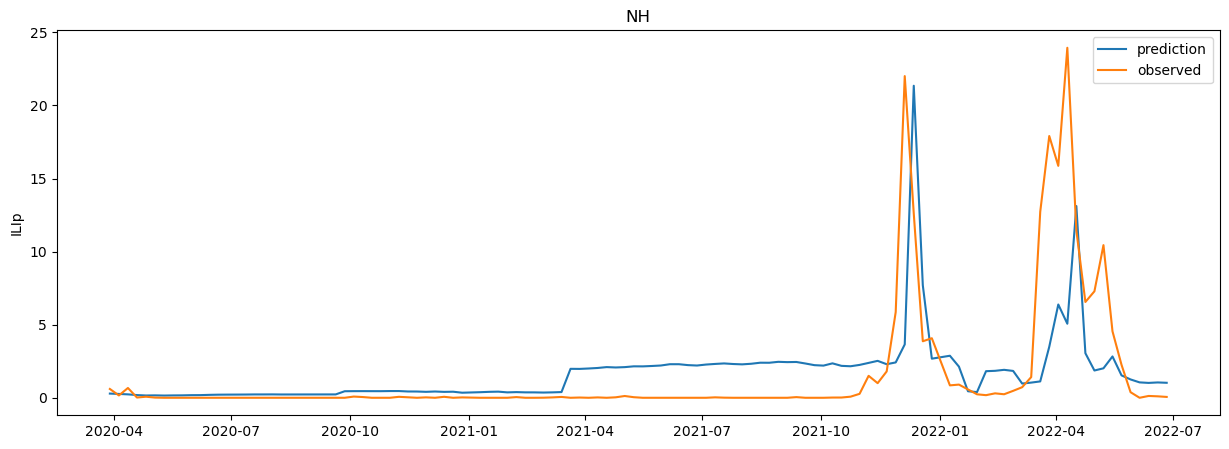

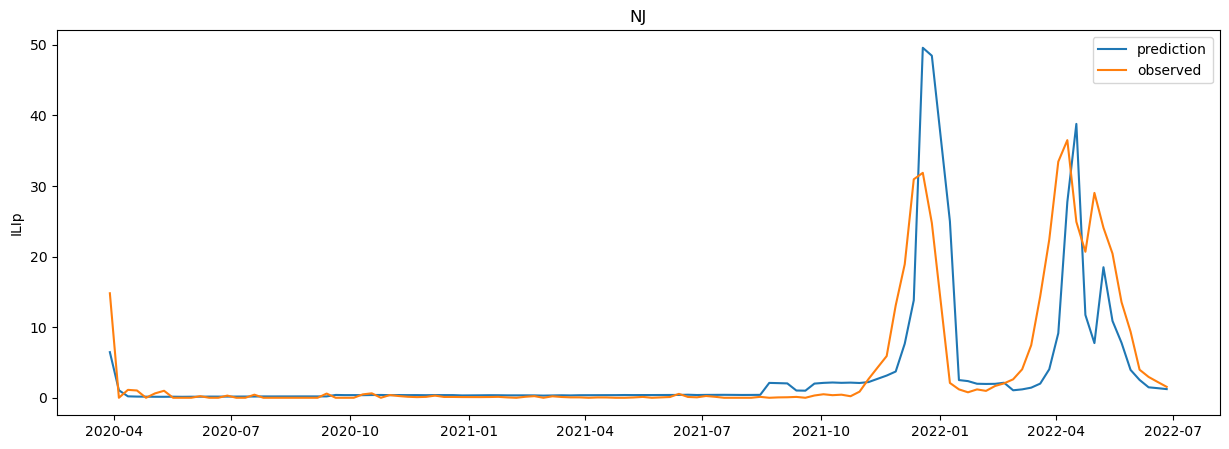

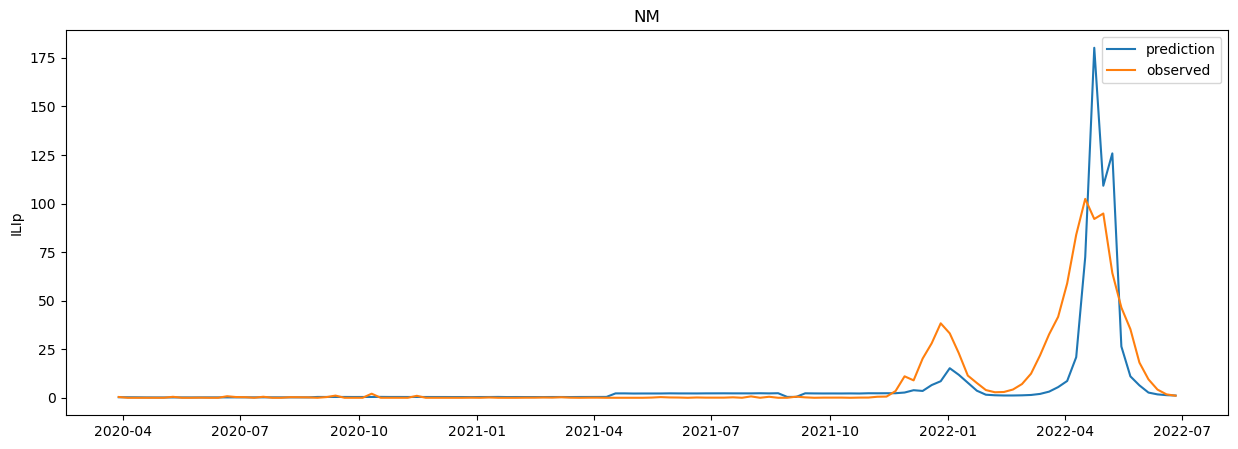

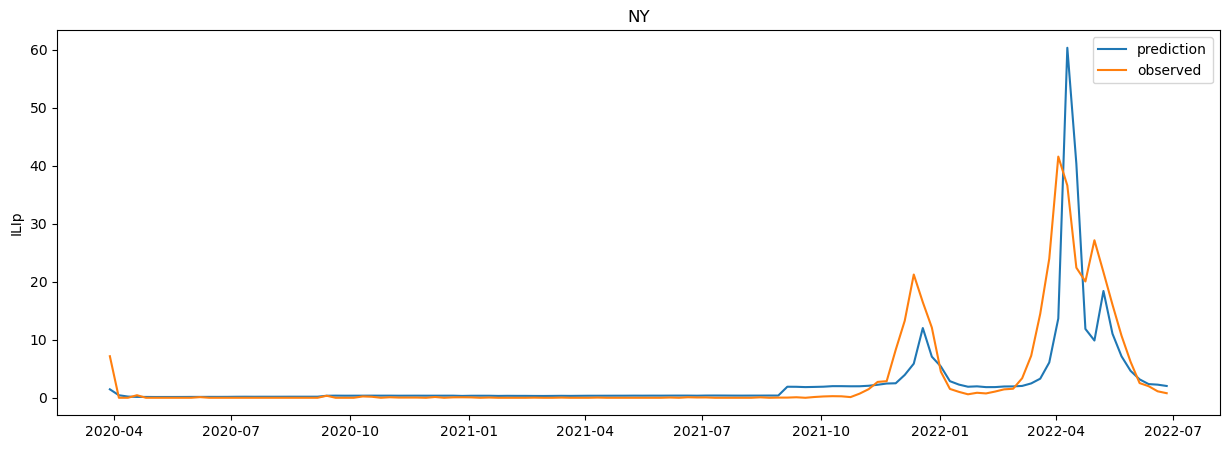

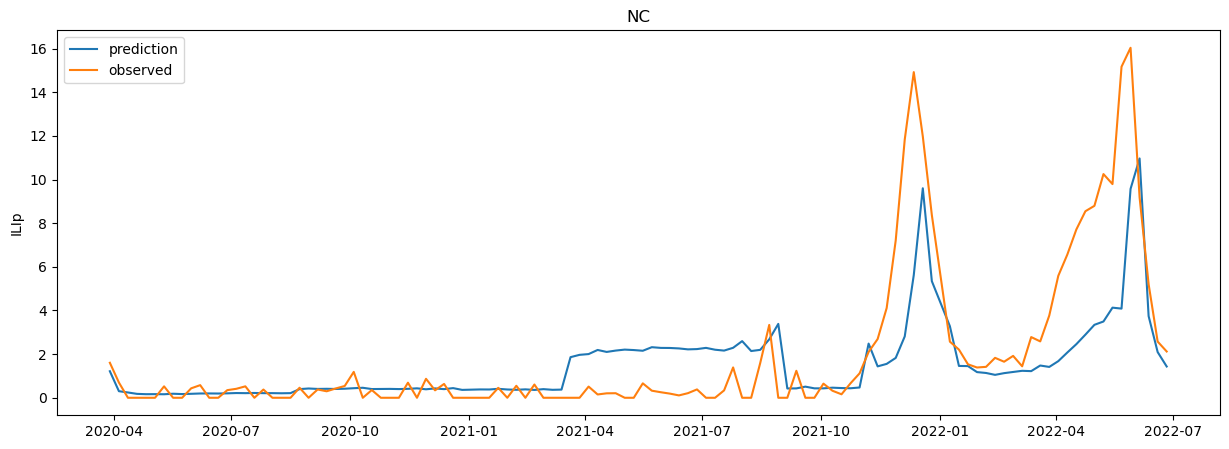

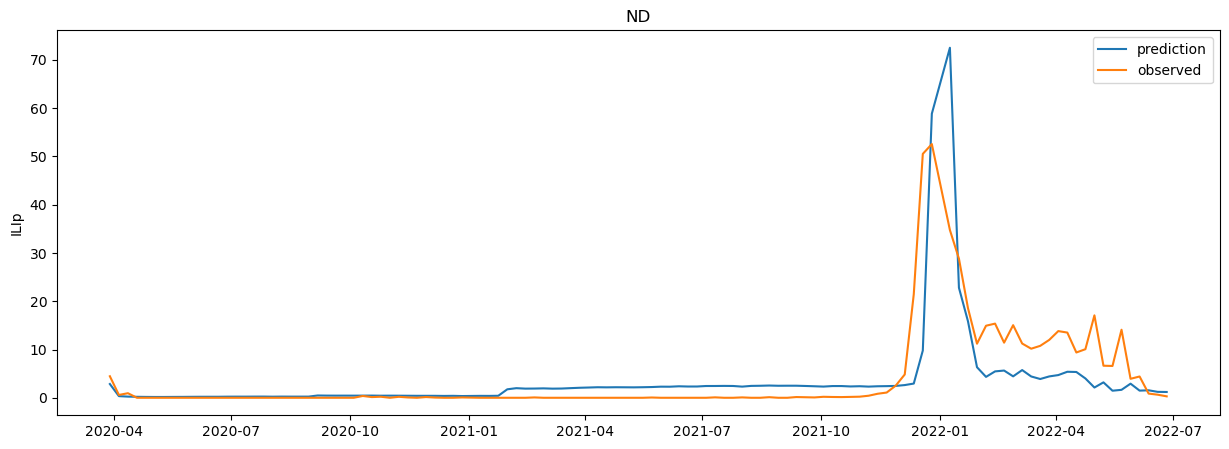

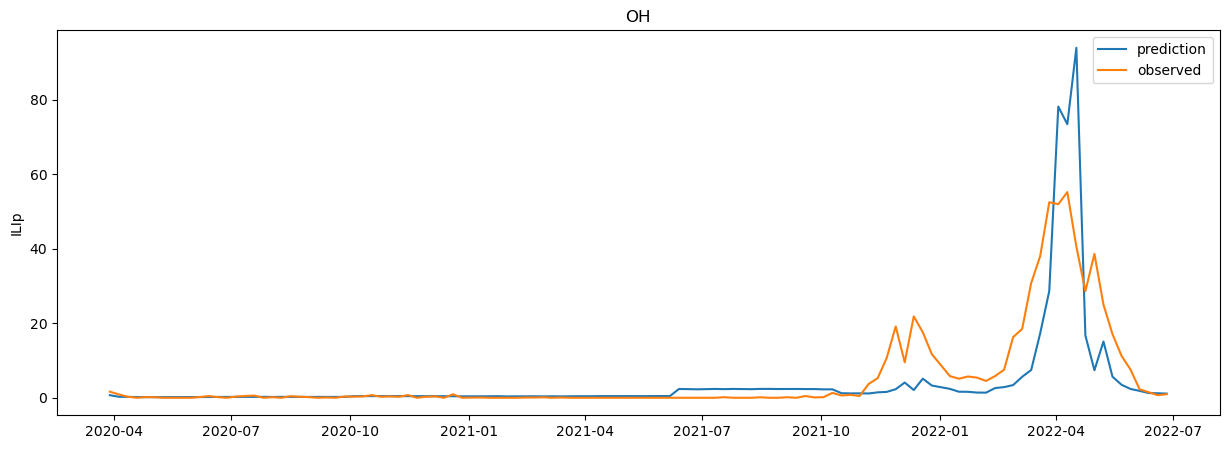

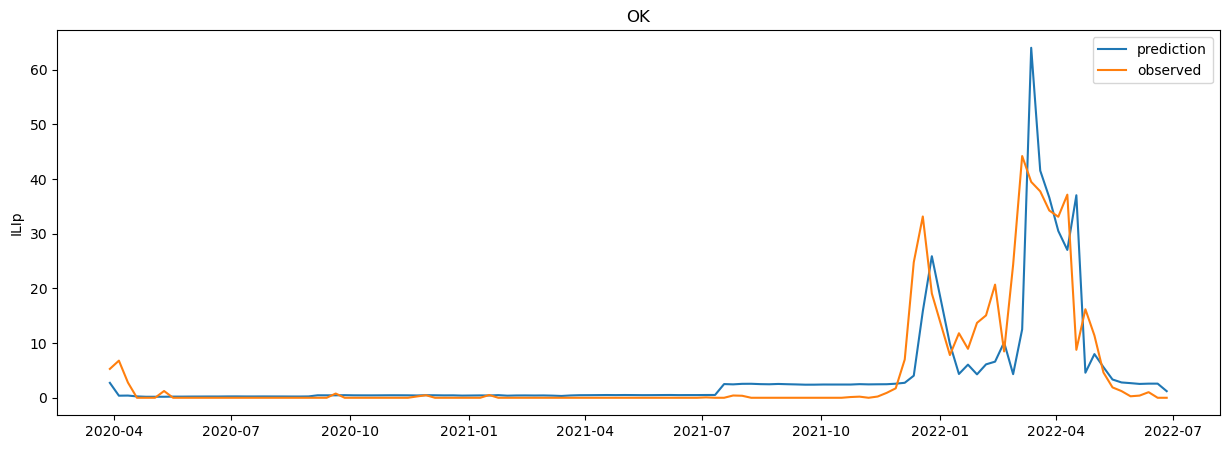

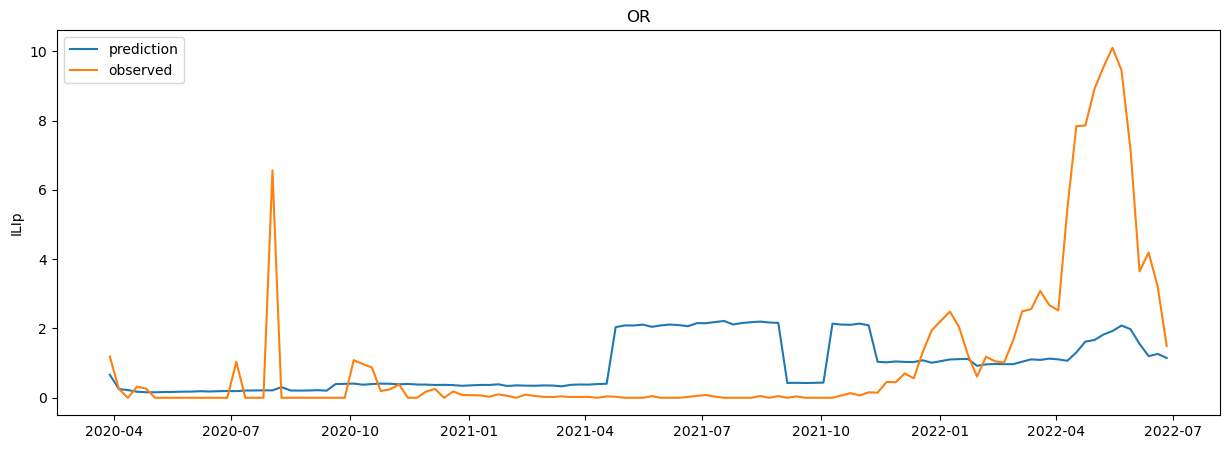

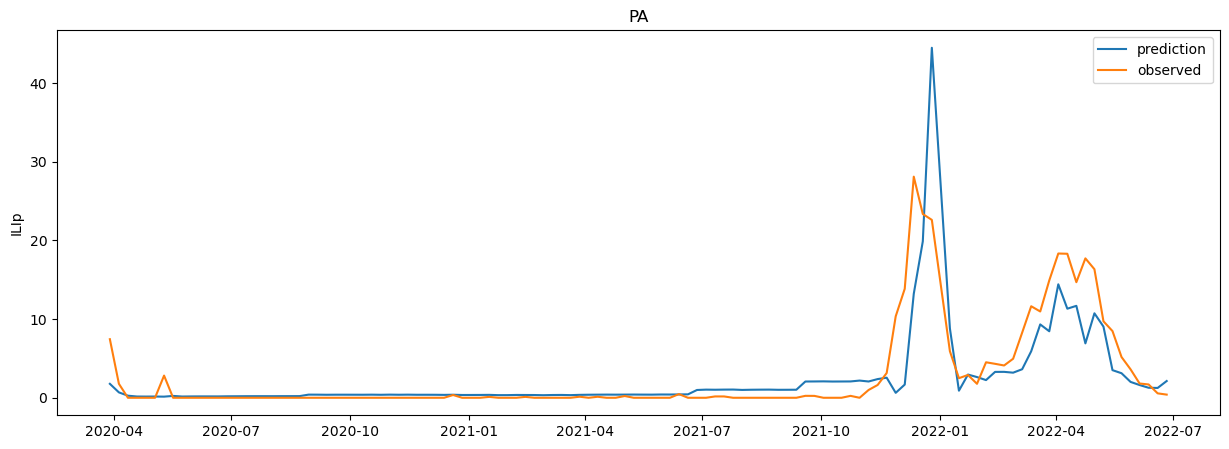

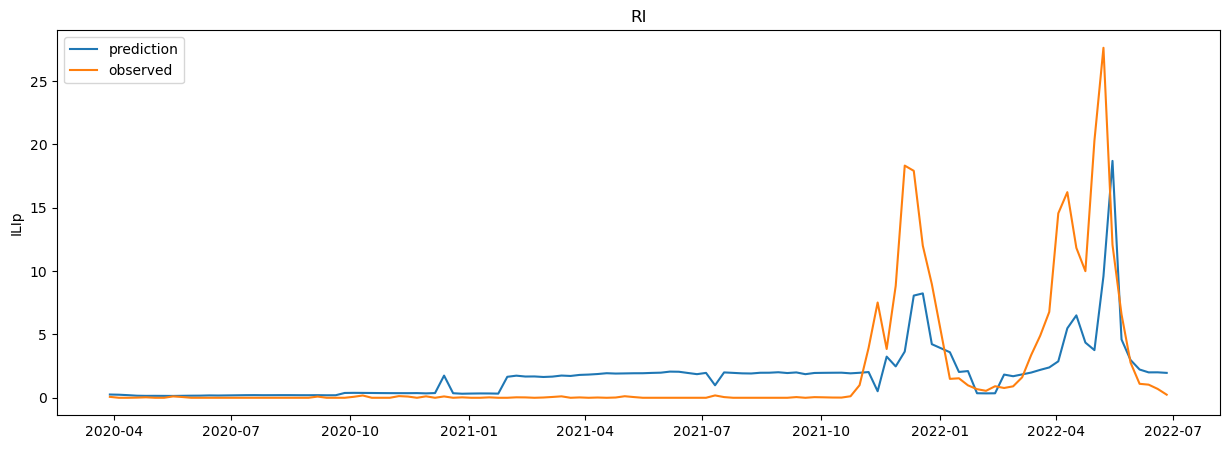

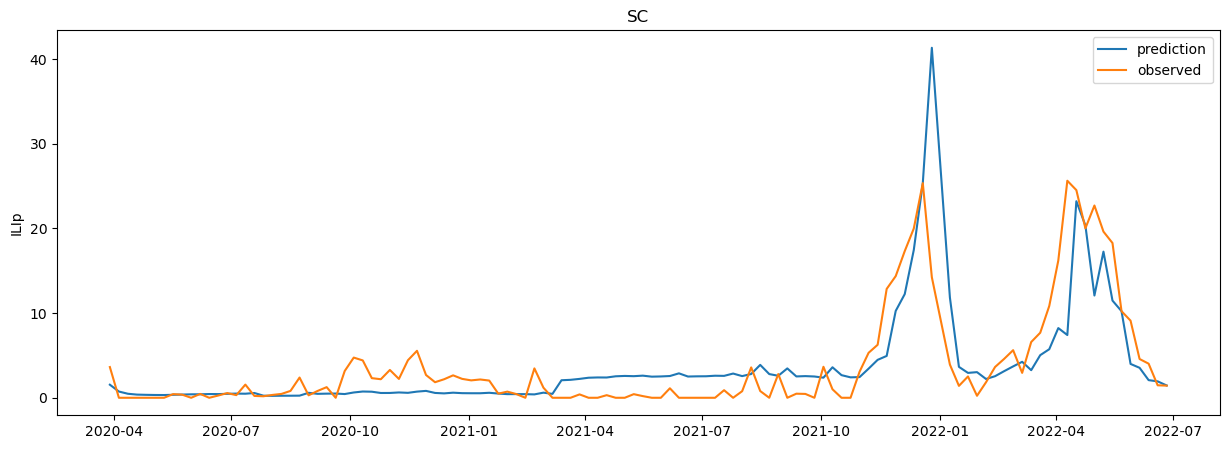

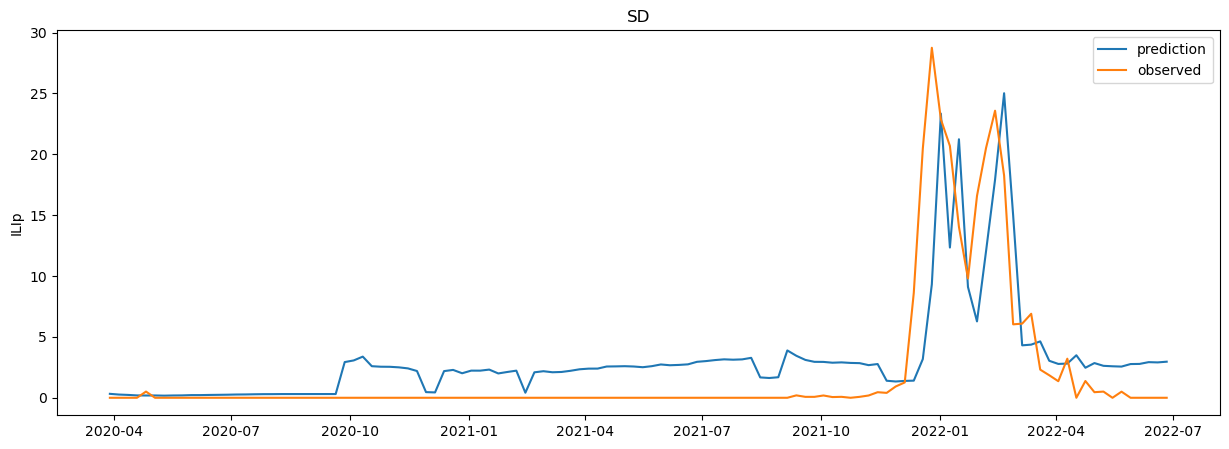

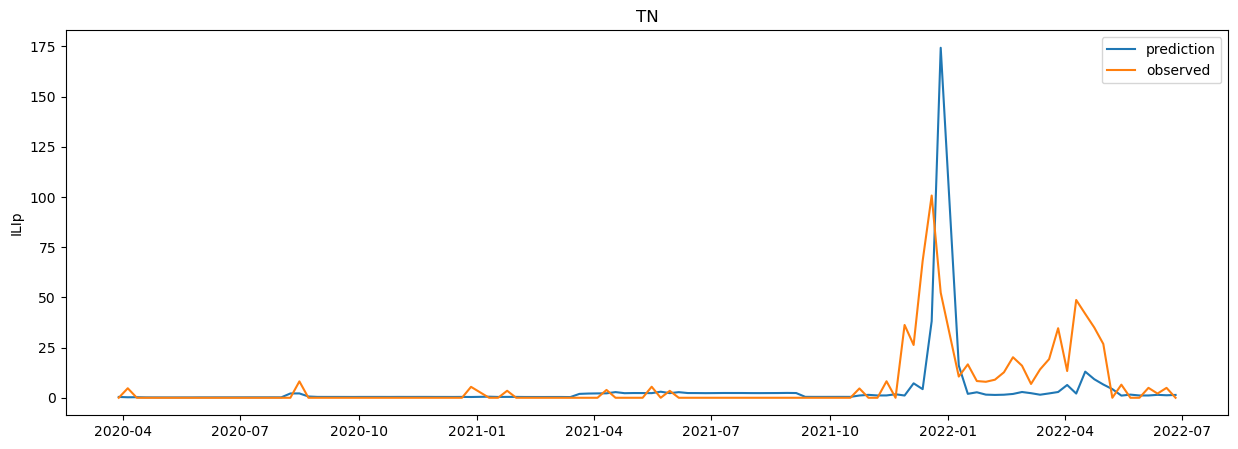

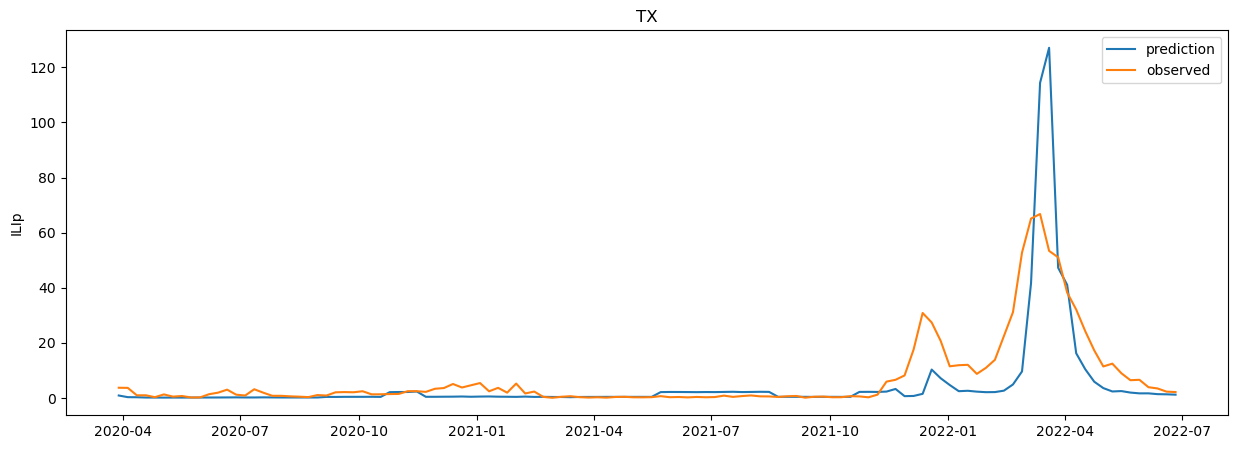

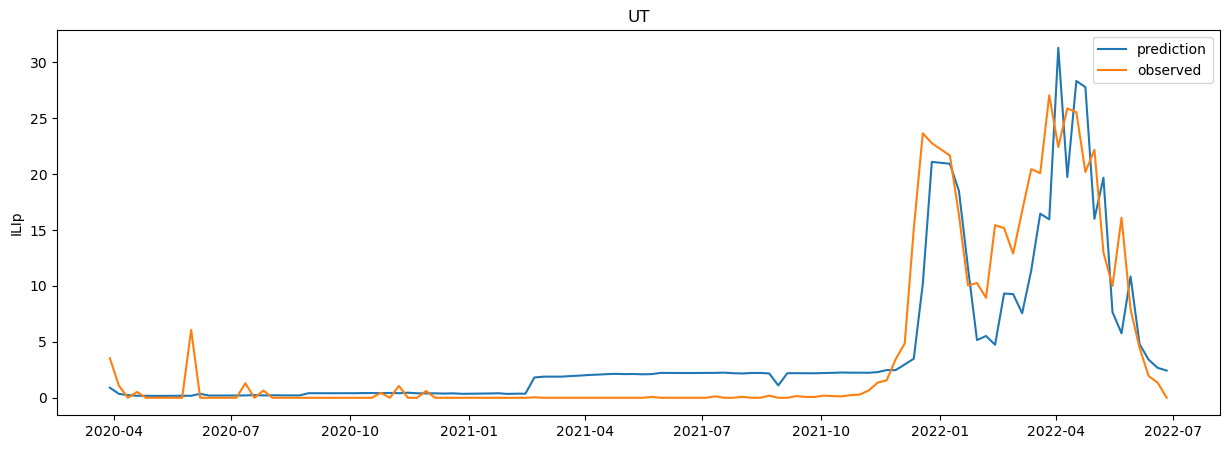

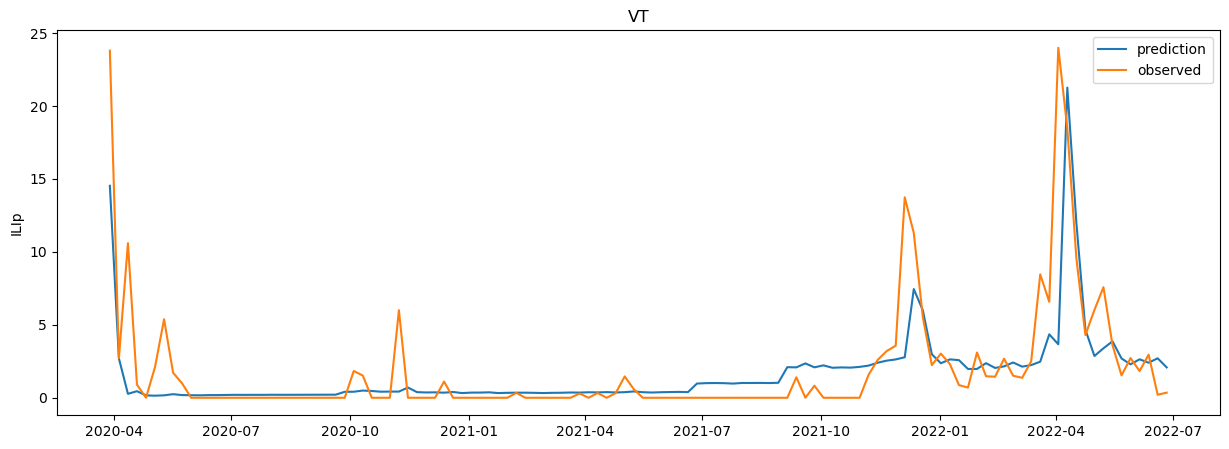

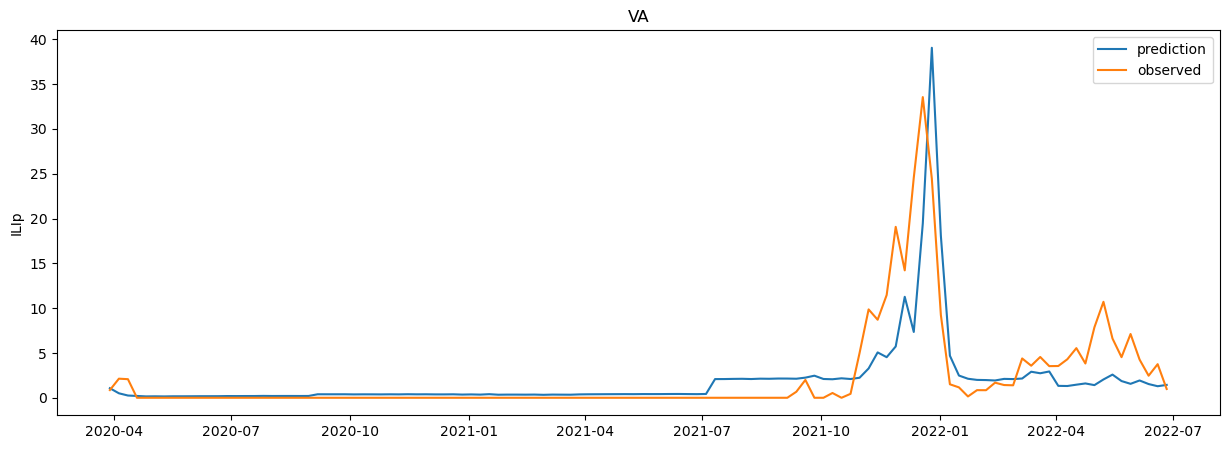

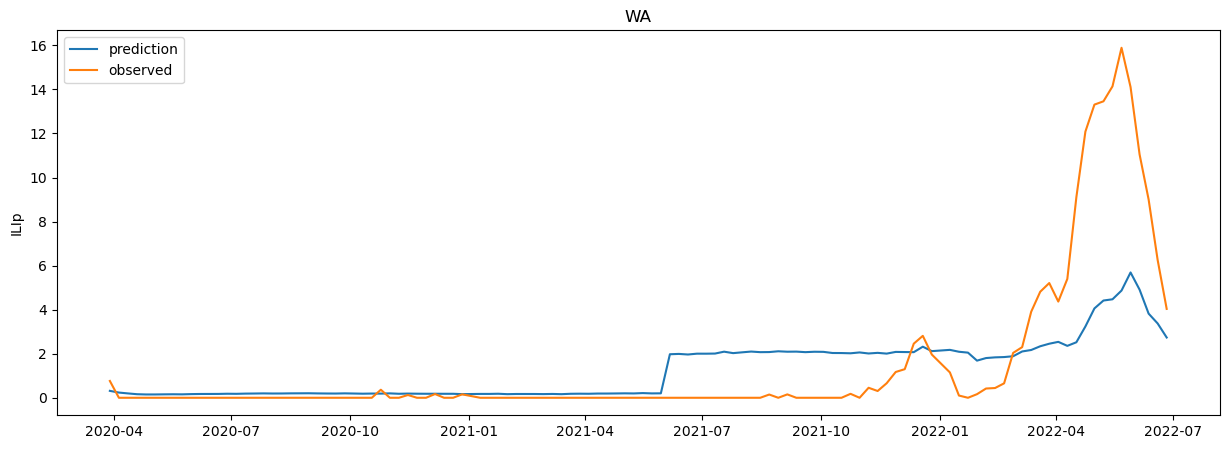

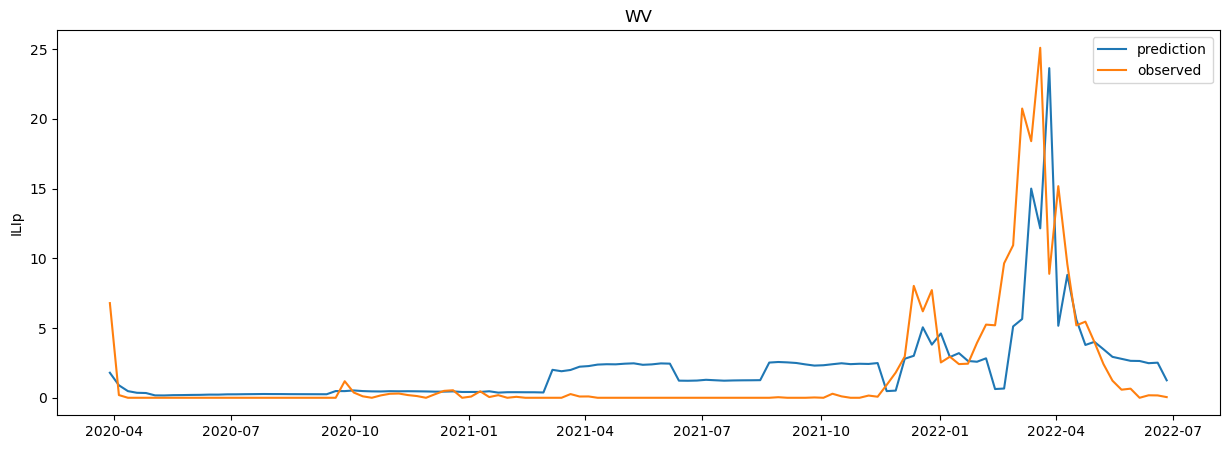

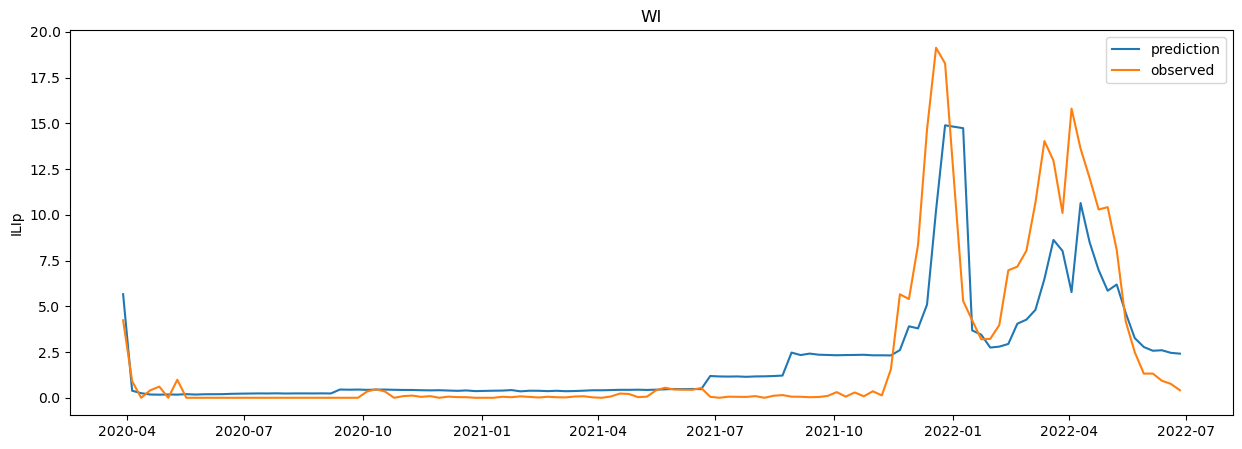

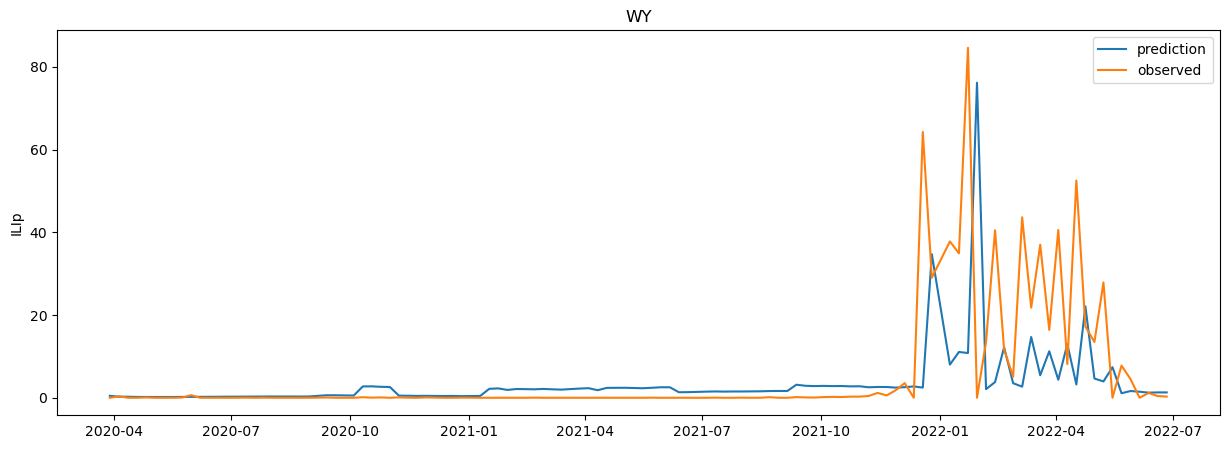

In [19]:
for idx in range(1,50):
    new_states=['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'GA', 'HI', 'ID',
           'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN',
           'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND',
           'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT',
           'VA', 'WA', 'WV', 'WI', 'WY']
    fig, ax = plt.subplots(figsize=(15,5))
    state_idxs = np.where(new_dat_mat[:, 5] == idx)[0]
    state_preds = pred[:, state_idxs]
    mean_pred=state_preds.mean(axis=0)
    observed=new_dat_mat[new_dat_mat[:, 5] == idx,0]
    plt.plot(df1[df1['state']==new_states[idx-1]]['ILIp']['2020-03-29':'2022-06-26'].index,mean_pred,label='prediction')
    plt.plot(df1[df1['state']==new_states[idx-1]]['ILIp']['2020-03-29':'2022-06-26'].index,observed,label='observed')
    plt.ylabel('ILIp')
    plt.legend()
    plt.title(f"{new_states[idx-1]}")
    plt.show()

In [ ]:

fig, ax = plt.subplots(figsize=(15,5))
plt.plot(df1[df1['state']==new_states[idx-1]]['ILIp']['2020-03-29':])

In [ ]:
"""def visualize_all_columns(df,ili):
    nrow=5
    ncol=2
    i=0
    fig, axes = plt.subplots(nrow, ncol,figsize=(15,15))
    fig.tight_layout()
    for r in range(nrow):
        for c in range(ncol):
            c1=ili
            c2=df[df.columns[i]]
            corr=round(c1.corr(c2),2)
            axes[r,c].plot(c1,label='il')
            axes[r,c].legend(['{:.2f}'.format(corr)],
                    loc = 'upper left',fontsize=20)
            ax2=axes[r,c].twinx()
            ax2.plot(c2,color='red',label=df.columns[i])
            ax2.legend()
            if i==len(df.columns)-1:
                break
            i+=1

def visualize_all_columns_outliers(df):
    nrow=5
    ncol=2
    i=0
    fig, axes = plt.subplots(nrow, ncol,figsize=(15,5))
    fig.tight_layout()
    for r in range(nrow):
        for c in range(ncol):
            axes[r,c].boxplot(df[df.columns[i]])
            axes[r,c].set_title(df.columns[i])
            if i==len(df.columns)-1:
                break
            i+=1
visualize_all_columns_outliers(df2_tx)"""